<h5 style='text-align:right; color:blue'><b>Last edit: 24-May-2024</b></h5>

<h1 style='text-align:center'><b>Predicting Hotel Booking Cancellations to Minimize Revenue Loss due to False Negative</b></h1>

# <b>1 Introduction</b>
<b>Content</b>: Efficient management in hotel booking plays significant roles in maximizing revenue and optimizing operational resources. But room booking cancellations pose a significant challenge to a hotel, leading to revenue loss and not optimal resource allocation. Understanding and predicing hoel booking cancellations can provide a competitive point by peveraging proractive measure to mitigate the negative consequences.

<b>Problem Statement</b>: Hospitality industry faces significant revenue loss and operational challenges due to hotel booking cancellations. Predicting cancellations in advance would enable the hotel proactively mitigate the negative impacts. However, traditional methods such as a historical data analysis or a manual risk assessment of cancellations are often labor intensive or not reliable.

<b>Objective</b>: This project aims to develop a machine learning classification model to predict hotel booking cancellations. By leveraging historical booking data and various features associated with each booking record, I intend to build a predictive model that can classify bookings into "Canceled" (`1`) or "Not Canceled" (`0`) categories. This model will enable hotel managers to allocate resources more effectively, optimize inventory management to reduce potential revenue loss due to cancellations.

<b>Analytical Approach</b>
- <b>Step-1</b>: Perform an exploratory data analysis (EDA) to understand the characteristics of data before building a classification model.
- <b>Step-2</b>: Build a classification model to predict the probability of customers canceling their hotel booking.
- <b>Step-3</b>: Identify key factors underlie the cancelation of hotel bookings.

<b>Metrics</b>: The focus of this analysis lies in mitigating the impact of false negatives (Type II errors), as they pose a higher financial risk to the hotel. However, a consideration is also given to minimizing false positives (Type I errors) to maintain operational efficiency.
- <b>Type I Error (False Positive)</b>: When the model incorrectly identifies a booking as canceled (Type I error), it may lead to overbooking or unnecessary actions by the hotel such as providing compensation to guests by offering similar or better room types.
	- Assuming an average loss is between USD10 and USD67.5 (see the simulation below) per false positive to upgrade hotel rooms, the total monthly loss will be in the range of USD1000 to USD6750 for 100 errors according to [Budget Your Trip](https://www.budgetyourtrip.com/hotels/portugal-PT). 
- <b>Type II Error (False Negative)</b>: When the model fails to predict a cancellation (Type II error), the hotel may lose revenue equivalent to the average price of a hotel room. In Portugal, this amounts to USD99 per night according to [Budget Your Trip](https://www.budgetyourtrip.com/hotels/portugal-PT).
	- Assuming the model makes 100 false negatives in a month, the total financial loss for the hotel could reach USD9,900.

Given the higher financial implications of Type II errors, the primary focus of the classification model is to minimize their occurrence. Therefore, the main evaluation metric for model performance will be $F_2$ score which provides a balanced consideratrion of precision and recall, with greater emphasis on recall to reduce Type II errors.

<b>Dataset</b>: A dataset containing historical hotel booking records, including information such as booking dates, customer demographics, booking channels, room types, and reservation details will be utilized to build a predictive model. The dataset will be preprocessed to handle missing values, outliers, and categorical variables before training the classification model.

<b>Features</b>
- `country` (string): Country of origin.
- `market_segment` (string): Market segment designation. 
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking.
- `booking_changes` (integer): Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
- `deposit_type` (string): Indication on if the customer made a deposit to guarantee the booking. 
- `days_in_waiting_list` (integer): Number of days the booking was in the waiting list before it was confirmed to the customer.
- `customer_type`: Type of booking.
- `reserved_room_type` (string): Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- `required_car_parking_space` (integer): Number of car parking spaces required by the customer.
- `total_of_special_request` (integer): Number of special requests made by the customer (e.g. twin bed or high floor).

<b>Target</b>
- `is_canceled` (integer): Value indicating if the booking was canceled (1) or not canceled (0).

<b>Expected Outcome</b>
By successfully developing and deploying the predictive model, we expect the following outcomes:
- Improved efficiency in resource allocation and inventory management.
- Reduction in revenue loss associated with booking cancellations.

In [85]:
# simulation of Type I error
average_cost = {
    'budget': 90,                       # Average of $58 and $122
    'midrange': 100,                    # Average of $98 and $102
    'luxury': 157.5                     # Average of $126 and $189
}

def simulate_compensation(original_room_type, upgraded_room_type):
    upgrade_cost = average_cost[upgraded_room_type] - average_cost[original_room_type]
    return upgrade_cost

original_room_budget = 'budget'         # guest originally booked a budget room
upgraded_room_midrange = 'midrange'     # hotel offers a free upgrade to a midrange room
original_room_midrange = 'midrange'     # guest originally booked a midrange room
upgraded_room_luxury = 'luxury'         # hotel offers a free upgrade to a luxury room

compensation1 = simulate_compensation(original_room_budget, upgraded_room_midrange)
compensation2 = simulate_compensation(original_room_midrange, upgraded_room_luxury)
compensation3 = simulate_compensation(original_room_budget, upgraded_room_luxury)

print(f"The hotel should compensate ${compensation1} for the budget-midrange upgrade.")
print(f"The hotel should compensate ${compensation2} for the midrange-luxury upgrade.")
print(f"The hotel should compensate ${compensation3} for the budget-luxury upgrade.")

The hotel should compensate $10 for the budget-midrange upgrade.
The hotel should compensate $57.5 for the midrange-luxury upgrade.
The hotel should compensate $67.5 for the budget-luxury upgrade.


In [86]:
import pandas as pd                                                         # for data wrangling
import numpy as np                                                          # for numerical operations
import matplotlib.pyplot as plt                                             # for data visualization
import seaborn as sns                                                       # for data visualization
from scipy.stats import skew, kurtosis, kstest, shapiro                     # for checking data distribution
import phik                                                                 # for checking correlations
import warnings                                                             # for disabling warnings
warnings.filterwarnings("ignore", category=UserWarning)                     # for disabling warning
import time                                                                 # for adding time lapse
from sklearn.metrics import fbeta_score, make_scorer                        # for adding metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay        # for showing confusion matrix
from sklearn.inspection import permutation_importance                       # for permutation importance
import dice_ml                                                              # for counterfactual explanation
from sklearn.model_selection import LearningCurveDisplay, learning_curve    # for learning curve
from pycaret.classification import *                                        # for modeling
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder           # for feature engineering
from sklearn.preprocessing import RobustScaler, PolynomialFeatures          # for feature engineering
from pycaret.internal.preprocess.transformers import TransformerWrapper     # for creating pipeline
from category_encoders import BinaryEncoder                                 # for feature engineering
from sklearn.model_selection import train_test_split                        # for data spliting

# <b>2 Data Understanding and Exploratory Data Analysis</b>
## <b>2.1 Initial Data Inspection</b>

In [87]:
# define function to inspect dataframe
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NApercent': (df.isna().mean() * 100).round(2).tolist(),
        'Nduplicate': df.duplicated().sum(),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [88]:
# import dataset
df = pd.read_csv('../data/dataset.csv')

# inspect data
inspect_dataframe(df)

The dataframe contains 83573 rows and 11 cols.


,ColumnName,Nrow,DataType,NApercent,Nduplicate,UniqueValue,Sample
0,country,83573,object,0.42,73371,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, B..."
1,market_segment,83573,object,0.00,73371,8,"[Offline TA/TO, Online TA, Direct, Groups, Cor..."
2,previous_cancellations,83573,int64,0.00,73371,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19,..."
3,booking_changes,83573,int64,0.00,73371,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12,..."
4,deposit_type,83573,object,0.00,73371,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,83573,int64,0.00,73371,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31..."
6,customer_type,83573,object,0.00,73371,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,83573,object,0.00,73371,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,83573,int64,0.00,73371,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,83573,int64,0.00,73371,6,"[0, 2, 1, 3, 4, 5]"


<b>Comment</b>
- <b>General Observation</b>
    - The dataset contains 83,573 booking records in and 11 columns, including `is_canceled` as the target variable.
    - Based on the columns, the categorical variables (object) are `country`, `market_segment`, `deposit_type`, `customer_type`, and `reserved_room` while the numerical columns (int64) are `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`, `total_of_special_request`.
    - Other than these, the dataset also has `is_cancelled` which will be used as the target variable. It consists of binary numbers, i.e., `0` for not canceled and `1` for canceled.
    - The missing value rate is 0.42% detected in column `country`. This issue will be further checked in the following section.
- <b>Notes on data types and scales of measurement</b>
    - All categorical variables will be converted into numerical (e.g., onehot, binary, or ordinal encodings) so they can be processed in the modeling process. And as none of these variables contains intrinsic orders (or ranks) in their categories, none of them will be converted using ordinal encoding. 
    - Numerical variables will also be pre-processed in order to make them have the same unit. For example, the range of values in `days_in_waiting_list` is wide, starting from 0 to 391, whereas values in `total_of_special_requests` range between 0 to 5. If the values are not rescaled, `days_in_waiting_list` will affect the model due to the larger values.
- <b>Scales of measurement</b>
    - Nominal: values with no particular orders. In the dataset, nominal columns are `country`, `market_segment`, `deposit_type`, `customer_type`, `reserved_room_type`, and `is_canceled`
    - Ordinal: values with ranked order. In the dataset there are no ordinal columns.
    - Interval: The interval between two numerical values should be equal, e.g., time. But there are no interval data in the dataset.
    - Ratio: Scale with equal interval between values and possibility of true zero. In the dataset, ratio includes `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`, and `total_of_special_requests`.

In [89]:
# get descriptive summary
display(df.describe().round(3),
        df.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000,83573.000,83573.000,83573.000,83573.000,83573.000
mean,0.087,0.221,2.331,0.063,0.573,0.368
std,0.841,0.649,17.673,0.247,0.795,0.482
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,1.000,1.000
max,26.000,21.000,391.000,8.000,5.000,1.000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


<b>Comment</b>
- <b>Numerical variables</b>
    - `previous_cancellations`: On average, bookings have very few previopus cancellations but some bookings ahve as many as 26 cancellations.
    - `booking_changes`: The majority of bookings have no changes but a few have up to 21 changes indicating variability in reservation modifications.
    - `days_in_waiting_list`: While most bookings spend no time on the waiting list, some have waited for as many as 391 days with considerable variability.
    - `required_car_parking_spaces`: Most bookings don't require parking spaces but a few require up to 8 spaces.
    - `total_of_special_requests`: Typically, bookings have few special requests, but some have as many as 5.
    - `is_canceled`: The range of values in the target variable is between 0 (`Not Canceled`) and 1 (`Canceled`). About 36.8% of the total bookings bookings are canceled.
- <b>Categorical variables</b>
    - `country`: The majority of bookings originate from Portugal (PRT), accounting for 34K+ out of 83K+, showing diversity in booking origins.
    - `market_segment`: The most common market segment is Online Travel Agent (Online TA) with 39.4K bookings, indicating the primary channel for bookings.
    - `deposit_type`: Most bookings are made without deposits (No Deposit), comprising 73.3K out of 83K.5 bookings, suggesting a prevalent payment method.
    - `customer_type`: The majority of customers are transient, with 62.7K transient bookings, indicating a high proportion of short-stay guests.
    - `reserved_room_type`: The most frequently reserved room type is type A, with 60K bookings, indicating popularity or availability of this room type.

## <b>2.2 Exploratory Data Analysis</b>
As mentioned in the Introduction section, this section attempts to understand the patterns of the data before creating a classification model. To accomplish this task, cancellation statuses in column `is_canceled` will be paired up with other categories. But it is important to note that this section is only meant to understand the data patterns prior to modeling only, not to provide insights to the stakeholder (hotel managers). For example, the EDA focuses on whether there are any medium to high correlations between features, whether the distributions of data across different variables are normal, and how different categorical values are distributed in the variables.

### <b>2.2.1 Expoloration</b>
#### <b>Check distribution of data</b>

In [90]:
# check data distribution: Numerical variables
df_numeric = df.select_dtypes(include='number')

ks_pvalues = df_numeric.apply(lambda col: kstest(col, 'norm')[1]).values
sw_values = df_numeric.apply(lambda col: shapiro(col)[1]).values

pd.DataFrame({'column': df_numeric.columns,
              'skewness': df_numeric.apply(skew).round(2).values,
              'kurtosis': df_numeric.apply(kurtosis).round(2).values,
              'ks_pvalue': ks_pvalues.round(2),
              'sw_pvalues': sw_values.round(2)
})

,column,skewness,kurtosis,ks_pvalue,sw_pvalues
0,previous_cancellations,24.41,673.23,0.0,0.0
1,booking_changes,6.00,81.72,0.0,0.0
2,days_in_waiting_list,11.89,184.73,0.0,0.0
3,required_car_parking_spaces,4.33,36.70,0.0,0.0
4,total_of_special_requests,1.35,1.50,0.0,0.0
5,is_canceled,0.55,-1.70,0.0,0.0


<b>Comment</b>
- With <i>p</i>-values of both Kolmogorov-Smirnov and Shapiro-Wilk tests, all data in all columns indicate deviation from the normal distribution.
- The table also informs about the skewness (symmentry of the distribution) and kurtosis (peakedness/flateness of the distribution). The values on the tables indicate substantial non-normality given their large magnitudes.
    - `previous_cancellations`: Both skewness and kurtosis values are extremely high, suggesting highly skewed distribution with a long tail on the positive side. Due to its skewness, it is likely for this variable to contains outliers. But this part will be further explored in the following section.
    - `booking_changes`: Both values are also high although not as high as the first variable. 
    - `days_in_waiting_list`: Both skewness and kurtosis values are very high, indicating highly skewed distribution with heavy tailedness.
    - `total_of_special_request`: Because the kurtosis is small, the peakedness is more normal than the previous variables.
    - `is_canceled`: The negative kurtosis value suggests the distribution looks slightly flatten.

#### <b>Check correlation between columns in dataset</b>

Correlation tests need to be carried out even though my goal is to build a classification model. Checking correlations may help identifying potential multicollinearity which can affect the realiability of the classification model.

In [91]:
# check correlation: Numerical variables
(df.select_dtypes(include='number')
 .corr(method='spearman')
 .style.background_gradient(cmap='YlOrRd')
 .format('{:.2f}'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
previous_cancellations,1.00,-0.07,0.12,-0.04,-0.13,0.27
booking_changes,-0.07,1.00,-0.02,0.08,0.04,-0.18
days_in_waiting_list,0.12,-0.02,1.00,-0.04,-0.13,0.10
required_car_parking_spaces,-0.04,0.08,-0.04,1.00,0.09,-0.20
total_of_special_requests,-0.13,0.04,-0.13,0.09,1.00,-0.26
is_canceled,0.27,-0.18,0.10,-0.20,-0.26,1.00


<b>Comment</b>
- The output above summarizes correlation tests across different numerical variables in the dataset using Spearman $\rho$. The non-parametric test was considered because the distribution of numerical data is non-normal.
- Based on the correlation matrix, all variables, except self-pairs (e.g., `previous_cancellations` vs `previous_cancellations`), have weak negative or positive relationships, ranging from -0.26 to 0.27.
- Moreover, due to the limitation of Spearman $\rho$ correlation coefficient, the correlation between columns containing categorical data, especially against the target column `is_canceled` have not been tested. To be able to test the correlations among them, $\phi k$ (phi $k$) will be utilized.

In [92]:
# check correlation: categorical variables + is_canceled
(df.loc[:, ['country', 'market_segment', 'deposit_type', 'customer_type', 'reserved_room_type', 'is_canceled']]
 .phik_matrix(interval_cols=['is_canceled'])
 .style.background_gradient(cmap='YlOrRd')
 .format('{:.2f}'))

,country,market_segment,deposit_type,customer_type,reserved_room_type,is_canceled
country,1.00,0.45,0.55,0.24,0.24,0.44
market_segment,0.45,1.00,0.51,0.56,0.28,0.36
deposit_type,0.55,0.51,1.00,0.10,0.25,0.30
customer_type,0.24,0.56,0.10,1.00,0.18,0.20
reserved_room_type,0.24,0.28,0.25,0.18,1.00,0.10
is_canceled,0.44,0.36,0.30,0.20,0.10,1.00


<b>Comment</b>
- Moderate correlations can be found in several variable pairs: 
    - `country` vs `market_segment` ($\phi k$ = 0.45)
    - `country` vs `deposit_type` ($\phi k$ = 0.55)
    - `market_segment` vs `customer_type` ($\phi k$ = 0.56)
    - `market_segment` vs `deposit_type` ($\phi k$ = 0.51)
    - `country` vs `is_canceled` ($\phi k$ = 0.44)
- Other than thse variable pairs, they show weak to moderate associations.
- Due to their moderate correlations and potential collinearity, three categorical variables will be dropped `country`, `market_segment`, `deposit_type`.

#### <b>Check proportion of cancelled and uncancelled bookings</b>

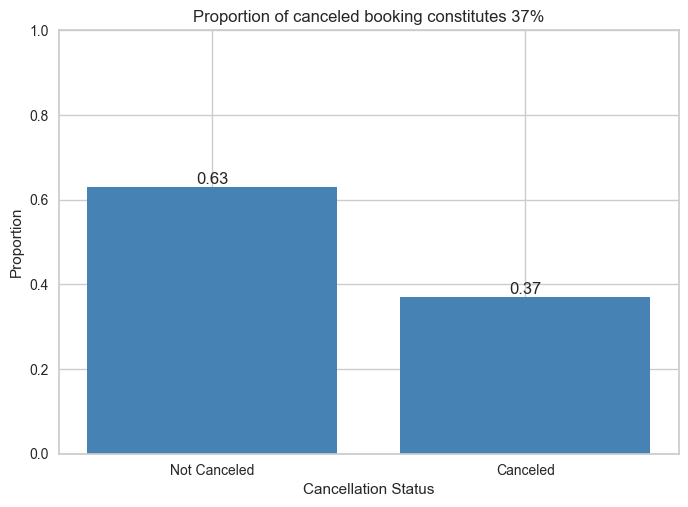

In [93]:
# calculate prop of each cancellation status
cancellation = (df['is_canceled']
                .value_counts(normalize=True)
                .reset_index()
                .round(2)
)
# create bar plot
plt.bar(cancellation['index'], cancellation['is_canceled'], color=['steelblue', 'steelblue'])

# add labels and title
plt.xlabel('Cancellation Status')
plt.ylabel('Proportion')
plt.title('Proportion of canceled booking constitutes 37%')

# add percentage labels
for i in range(len(cancellation)):
    plt.text(cancellation['index'][i], cancellation['is_canceled'][i], 
             f'{cancellation["is_canceled"][i]}', ha='center', va='bottom')

# show plot
plt.xticks([0, 1], ['Not Canceled', 'Canceled'])
plt.ylim(0, 1)
plt.show()

<b>Comment</b>
- The cancelation rate is quite high. The rate constitutes 37% from the total bookings in the hotel. While it is slightly lower than the global hotel booking [cancelation rate](https://hospitalitytech.com/global-cancellation-rate-hotel-reservations-reaches-40-average) (40%), this number has been quite alarming given the financial loss faced by the hotel.
- Another important point is the balanced or imbalanced proportion. According to the bar plot, the proportion between category 'Canceled' and 'Not Canceled' is slightly imbalanced (0.37 vs 0.63) based on Brownlee (2020, p.6). Hovever, because <b>this proportion may change</b> because the data used for EDA has not been cleaned up yet. The data cleaning process is carried out in the next section.

#### <b>Check country origins with highest cancellation cases</b>

In [94]:
# get countries with highest cancellation cases
country_cancel = (df[df['is_canceled']==1]
                  .groupby('country')
                  .agg(func={'is_canceled':'count'})
                  .reset_index()
                  .sort_values(by='is_canceled', ascending=False))

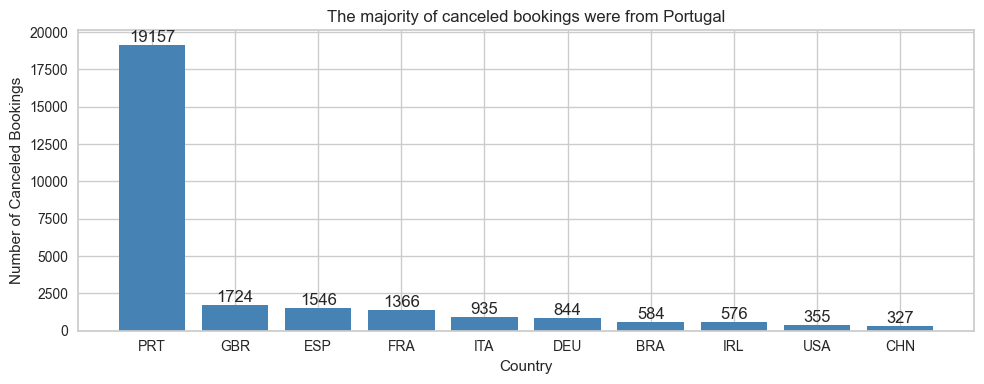

In [95]:
# create bar plot
plt.figure(figsize=(10, 4))
plt.bar(country_cancel['country'].head(10), 
        country_cancel['is_canceled'].head(10), 
        color='steelblue')

# add labels and title
plt.xlabel('Country')
plt.ylabel('Number of Canceled Bookings')
plt.title('The majority of canceled bookings were from Portugal')

# add labels to each bar
for i, value in enumerate(country_cancel['is_canceled'].head(10)):
    plt.text(i, value, str(value), ha='center', va='bottom')

# rotate x-axis labels
plt.xticks(rotation=0, ha='center')

# show plot
plt.tight_layout()
plt.show()

<b>Comment</b>
- Most guests who canceled the hotel bookings originated from Portugal (PRT) with 19.1K cancellations. This indicates that customers from this country may have a signficant impact on the hotel's cancellation rate.
- While there is also a considerable variation in cancellation rates across country of origins, it is clear that European countries such as the UK (GBR), Spain (ESP), France (FRA), Italy (ITA), and Germany (DEU) have relatively high numbers of cancellations.

#### <b>Check market segments with highest cancellation cases</b>

In [96]:
# get market segment with highest cancellation
segment_cancel = (df[df['is_canceled'] == 1]
                  .groupby('market_segment')
                  .size()
                  .reset_index(name='count')
                  .sort_values(by='count', ascending=False))

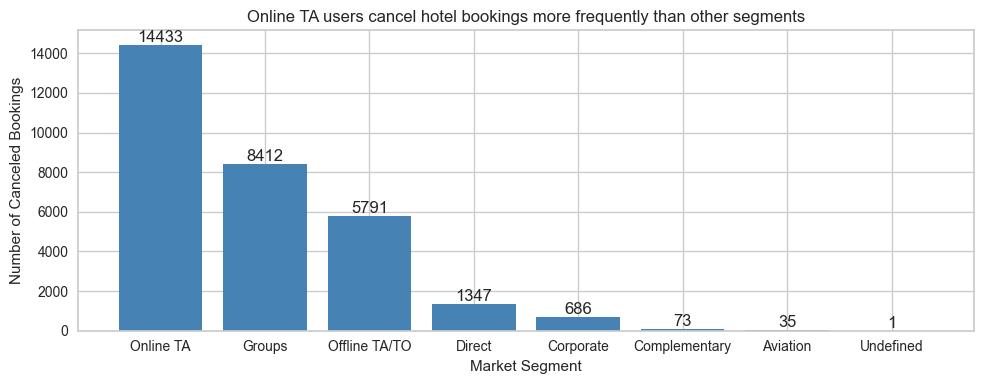

In [97]:
# Create bar plot
plt.figure(figsize=(10, 4))
bars = plt.bar(segment_cancel['market_segment'], 
               segment_cancel['count'], 
               color='steelblue')

# Add labels and title
plt.xlabel('Market Segment')
plt.ylabel('Number of Canceled Bookings')
plt.title('Online TA users cancel hotel bookings more frequently than other segments')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Add text labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{int(bar.get_height())}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

<b>Comment</b>
- Customers using Online Travel Agencies (Online TA) canceled the hotel bookings far more often than other market segments. The number of cancellations constitute 14.4k with the online TA. This means that customers booking through online TA contribute significantly to the hotel's cancellation count.
- In addition to Online TA, Groups and Offline TA/TO segments also have substantial cancellations with 8.4K and 5.7K cancellations, respectively. This suggests that group bookings and those made through traditional travel agencies or tour operators are prone to cancellations.
- <b>Next step</b>: Value `Undefined` in column `market_segment` will be removed because it will somehow be detected as an error by PyCaret.

In [98]:
# get deposit type with highest cancellation
deposit_cancel = (df[df['is_canceled'] == 1]
                  .groupby('deposit_type')
                  .size()
                  .reset_index(name='count')
                  .sort_values(by='count', ascending=False))

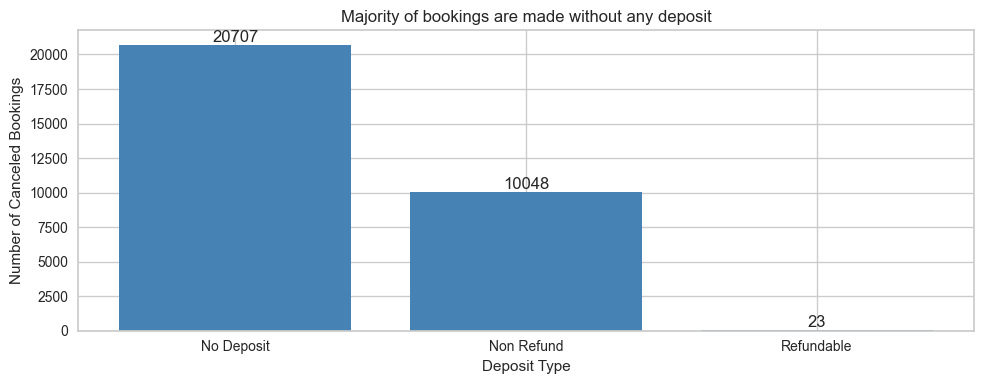

In [99]:
# Create bar plot
plt.figure(figsize=(10, 4))
bars = plt.bar(deposit_cancel['deposit_type'], 
               deposit_cancel['count'], 
               color='steelblue')

# Add labels and title
plt.xlabel('Deposit Type')
plt.ylabel('Number of Canceled Bookings')
plt.title('Majority of bookings are made without any deposit')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Add text labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{int(bar.get_height())}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

<b>Comment</b>
- Majority of bookings are made without deposits (No Deposit) with 207K counts, indicating a significant portion of hotel reservations is made without requiring any upfront deposit from the guests.
- The prevalence of bookings with no deposits indicates that hotel may need to adjust their booking policies to mitigate the risk of cancellations.

#### <b>Check customer types with highest cancellation cases</b>

In [100]:
# get customer types with highest cancellation
customer_cancel = (df[df['is_canceled'] == 1]
                  .groupby('customer_type')
                  .size()
                  .reset_index(name='count')
                  .sort_values(by='count', ascending=False))

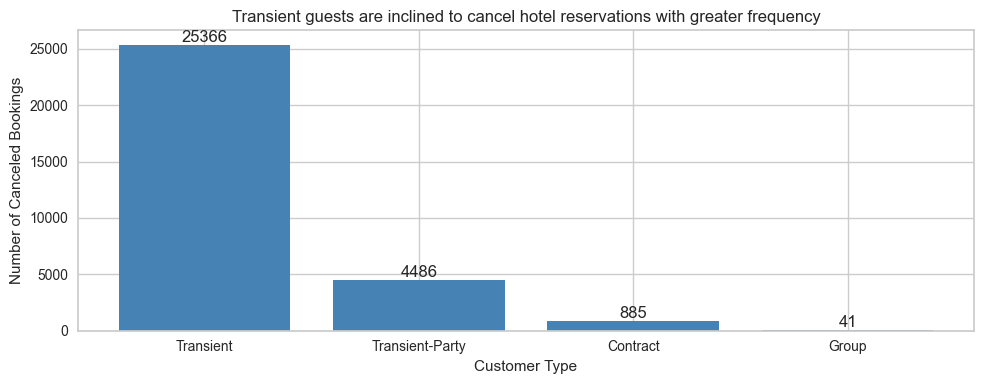

In [101]:
# Create bar plot
plt.figure(figsize=(10, 4))
bars = plt.bar(customer_cancel['customer_type'], 
               customer_cancel['count'], 
               color='steelblue')

# Add labels and title
plt.xlabel('Customer Type')
plt.ylabel('Number of Canceled Bookings')
plt.title('Transient guests are inclined to cancel hotel reservations with greater frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Add text labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{int(bar.get_height())}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

<b>Comment</b>
- The Transient customer type has the highest frequency of cancellations (253K).
- The frequency of cancellation from the Transient type is far higher than the rest customer types such as  Transient-Party, Contract, and Group.

#### <b>Check reserved room types with highest cancellation cases</b>

In [102]:
# get reserved room types with highest cancellation
reserved_cancel = (df[df['is_canceled'] == 1]
                  .groupby('reserved_room_type')
                  .size()
                  .reset_index(name='count')
                  .sort_values(by='count', ascending=False))

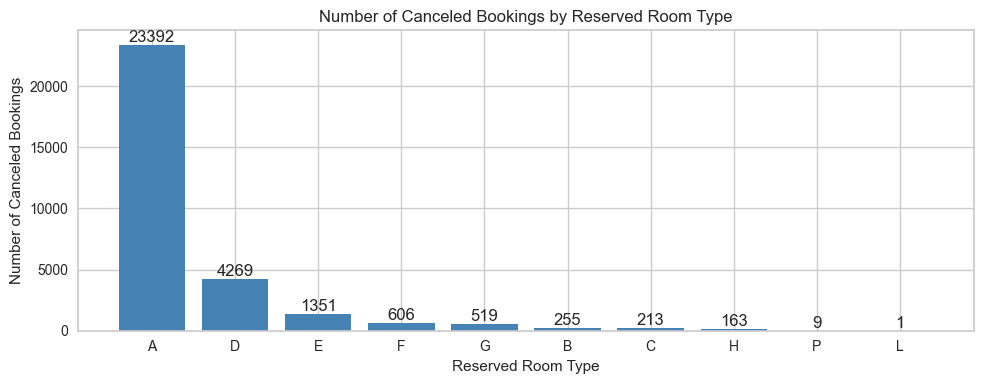

In [103]:
# Create bar plot
plt.figure(figsize=(10, 4))
bars = plt.bar(reserved_cancel['reserved_room_type'], 
               reserved_cancel['count'], 
               color='steelblue')

# Add labels and title
plt.xlabel('Reserved Room Type')
plt.ylabel('Number of Canceled Bookings')
plt.title('Number of Canceled Bookings by Reserved Room Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Add text labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{int(bar.get_height())}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

<b>Comment</b>
- The room type A has the highest number of cancellations with 23.3K counts, indicating that room type A is the most commonly reserved and subsequently cancelled.
- On the contrary to room A, type P and L have the lowest cancellation counts with only 9 and 1, respectively.

## <b>2.3 Summary</b>
- So far, we see that all numerical variables indicate non-normal data distribution, emphasizing the use of Spearman $\rho$ for the correlation test. 
- Both numerical (Spearman $\rho$) and categorical variables ($\phi k$) show either weak or moderate correlations. And for moderate correlations, `country`, `market_segment`, and `deposit_type` will be droped.
- There is an imbalanced data in the target variable (`is_canceled`) but since the duplicate check will be checked in the Data Preparation section, it remains an open question so far whether the proportion of categories in the target variable is *really* imbalanced.
- The majority of cancellations are associated with customers with the following characteristics: Most of them originate from Portugal; use online travel agencies; made bookings with no deposits; stay for a short period of time (transient); and book room type A.
- Moreover, in the Initial Data Inspection section, I already pointed out some possibility of using different data encoding techniques, particularly onehot or binary encoding. And as previously mentioned, to determine which encoding technique to choose will depend on the number of unique values in each categorical variables. Judging the count of unique values only, `market_segment`, `deposit_type`, and `customer_type` can be encoded using onehot encoder whereas binary encoding can be applied to `reserved_room_type` due to its high number of unique value.
- Feature engineering technique appropriate for umerical variables (`previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`, and `total_of_special_requests`) remains an open question and will further be explored in section 3 to check if there are outliers.

# <b>3 Data Preparation</b>
This section identifies and handles issues in the dataset prior to modeling such as (1) missing values, (2) duplicates, (3) outliers, (4) rare labels, and (5) cardinality. In addition to the identification and treatment, this section will also explores different feature engineering techniques for the data modeling. The output of this feature engineering is a pipeline for the modeling phase.

## <b>3.1 Data Cleaning</b>
### <b>3.1.1 Missing Value Identification & Treatment</b>

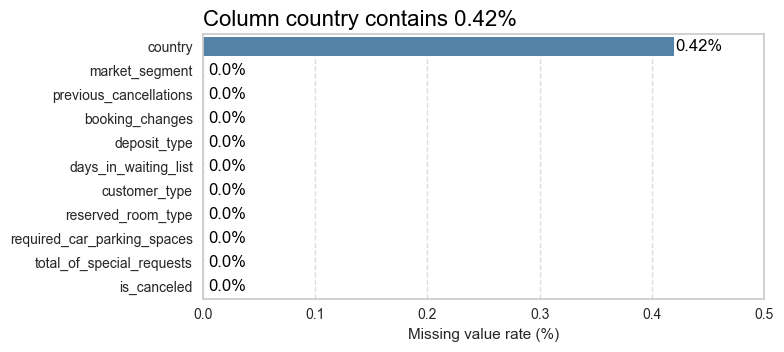

In [104]:
na_df = (df.isna().mean()*100).reset_index(name='percentage')
na_df['percentage'] = round(na_df['percentage'], 2)

plt.figure(figsize=(8, 4))

bar_plot = sns.barplot(
    data=na_df,
    y='index',
    x='percentage',
    color='steelblue',
    orient='h'
)

# Add text labels for each bar, closer to the bar end
for index, row in na_df.iterrows():
    bar_plot.text(row.percentage + 0.022, index, f'{row.percentage}%', color='black', ha="center", va="center")

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.ylabel('')
plt.xlabel('Missing value rate (%)')
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.title('Column country contains 0.42%', loc='left', fontsize=16, color='black')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [105]:
# Check for missing values in the 'country' column and the proportion of these missing values
country_missing_count = df['country'].isnull().sum()
country_missing_percentage = (country_missing_count / len(df)) * 100
print(f'Missing values in country: {country_missing_count}, which is {country_missing_percentage:.2f}% of the total')

Missing values in country: 351, which is 0.42% of the total


<b>Comment</b>
- The missing value rate is 0.42% of the total observations. Because of this small rate, two options are available: (1) Because the data type is categorical, data imputation using the mode (most frequent value) of values in column `country` can be done. The small rate will give a minimal effect on the distribution. (2) Alternatively, missing value removal can also be done due to the same consideration, i.e., small proportion of missing values.
- The missing values in column `country` will not be handled because this feature will be excluded from the modeling. My reason is
    - This feature shows a moderate correlation between different variables based on the $\phi k$ values, indicating potential collinearity when paired up with another categorical variable, as mentioned above.
    - This feature also contains a great number of unique value (high cardinality), potentially indicating rare labels. The high cardinality is usually related to rare labels. This will be checked deeper below.

### <b>3.1.2 Duplicated Value Identification & Treatment</b>

In [106]:
# check duplicate rate
(df.duplicated().sum()/len(df)*100).round(2)

87.79

In [107]:
# get top rows of duplicates
df[df.duplicated()].head(4)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
22,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
29,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,1,0
34,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1


<b>Comment</b>
- The dataset exhibits a high duplicate rate of 87.79%. This requires a removal as duplicates can significantly impact the performance of the classification model. For instance, the training set (`df_seen`) contains a number of rows with identical values to those in the test set (`df_unseen`). As a result, when evaluating the trained model with the test set, the model <u>memorizes</u> these values instead of <u>learning</u> the geneeral patterns, predisposing it to overfitting.
- In general overfitting cocurrs when a model encounters the same data points multiple times due to duplicates, the model will learn to fit the training data too closely, not learning the generalizable patterns. This can lead to poorer performance when the model is applied to new, unseen data even though high performance in the seen (training) data.

In [108]:
# potential remaining data
len(df) - df.duplicated().sum()

10202

<b>Comment</b>: The remaining data for bot training and testing the model will be 10,202 rows but since some moderately correlated features, namely `country`, `market_segment`, and `deposit_type` will be discarded later in the data modeling, duplicates may also appear. This underscores the importance of rechecking duplicates based on the remaining features listed below. Once again, this check and treatment must be done to minimize potential overfitting due to the presence of similar rows after data spliting.

In [109]:
# specify columns
cols = ['previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests']

# check the remainder
len(df) - df.duplicated(subset=cols).sum()

1275

<b>Comment</b>
- Although duplicate treatment has been done, duplicates appear again in the dataset after subsetting columns used for the modeling phase after discarding three correlated features (`country`, `market_segment`, and `deposit_type`) and separating the remaining features from `is_canceled` as the target.
- The presence of duplicates after the exclusion and split implies that some features have the same values with different output. For instance, row X and Y have the same values for their features but they have different cancellation status.
- This significant amount of data must be discarded in the modeling process because they are duplicates, posing an overfitting issue to the classification model.

In [110]:
# handle duplicates
df.drop_duplicates(subset=cols, keep='first', inplace=True)

# double check duplicates
df.duplicated().sum()

0

In [111]:
# check length of dataset
len(df)

1275

### <b>3.1.3 Outlier Identification</b>

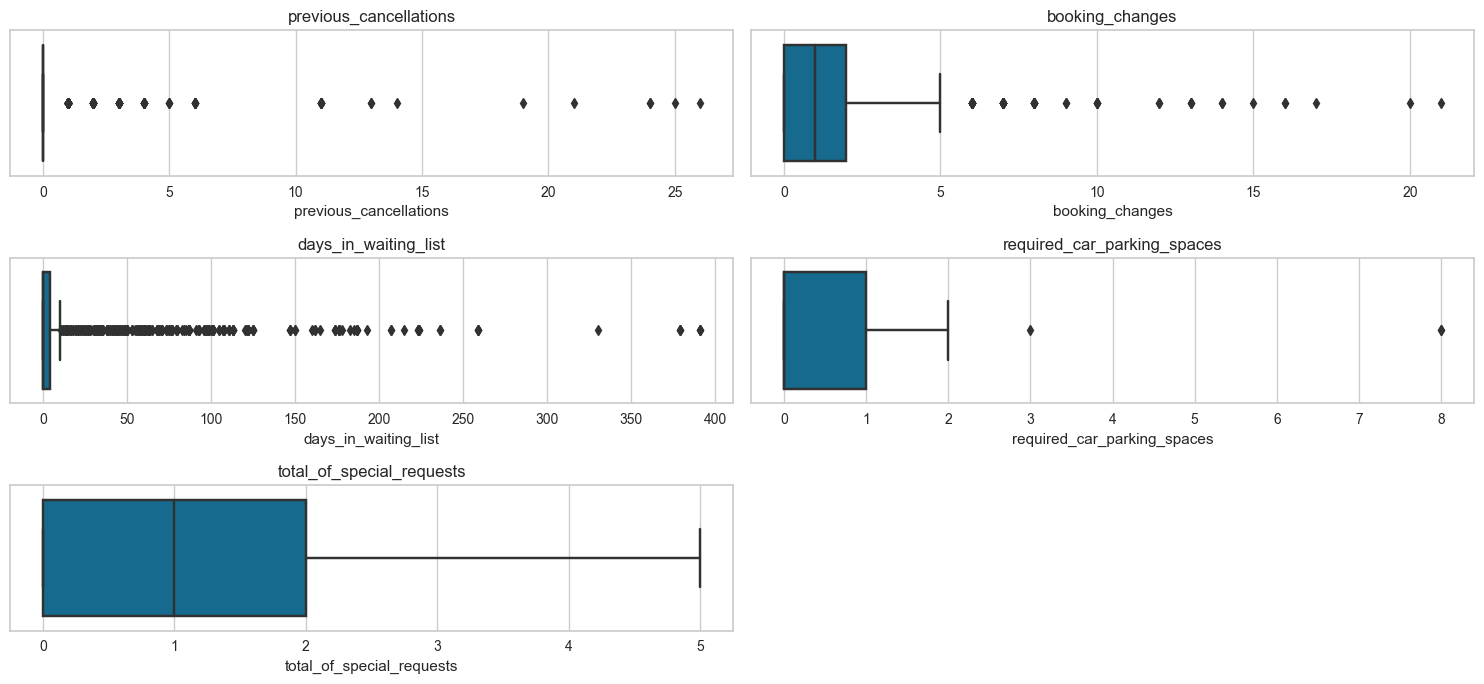

In [112]:
# define num cols
numerical_columns = df[['previous_cancellations', 'booking_changes', 
                        'days_in_waiting_list', 'required_car_parking_spaces', 
                        'total_of_special_requests']]

# setup up figure size
plt.figure(figsize=(15, 7))

# check outliers using boxplots
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'{col}')

plt.tight_layout()
plt.show()

In [113]:
# create function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{column}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

In [114]:
# detect outliers
for col in numerical_columns.columns:
    detect_outliers(df, col)

The number of outliers in 'previous_cancellations' is 219 or 17.18% of the total data (1275 rows).
The number of outliers in 'booking_changes' is 59 or 4.63% of the total data (1275 rows).
The number of outliers in 'days_in_waiting_list' is 293 or 22.98% of the total data (1275 rows).
The number of outliers in 'required_car_parking_spaces' is 3 or 0.24% of the total data (1275 rows).
The number of outliers in 'total_of_special_requests' is 0 or 0.00% of the total data (1275 rows).


<b>Comment</b>
- Except column `total_of_special_request`, all numerical columns specified in the code contain outliers, starting from `required_car_parking_spaces` with 0.24% of outliers to `days_in_waiting_list` with a considerable number of outliers (22.98%).
- While winsorization and log transformation are some possible treatments to outliers, winsorizing data with a considerable number of outliers in `days_in_waiting_list` and `previous_cancellations` can significantly change the data distribution, making the transformed version have have considerable difference to the original one. Additionally, log tansformed data will make the interpretation less intuitive because the values are in a logarithmic scale. Log transformation will also change the underlying structure of original data if it has a non-linear relationship
- As a consequence, at least two options to treat outliers are available, namely robust scaling and equal frequency discretization (binning):
    - <b>Equal frequency binning</b>: This binning technique group numerical values into a number of bins with the same number of observations. While this technique can reduce the effect of outliers due to grouping them into the equal frequency, binning can cause information loss which is crucial for modeling.
    - <b>Robust scaling</b>: This scaling technique convert numerical features into a similar range and is less sensitive to outliers since it uses median and interquartile range (IQR) in its formula. This technique will be particularly useful when the classification task is done by using distance-related models such as k-Nearest Neighbors or Support Vector Machines
- Since both feature engineering techniques can be used to minimize the effects of extreme values in numerical features, both techniques will be experimented in the next section to see which techniques can produce a better performing classification model.

### <b>3.1.4 High Cardinality Identification</b>
Checking cardinality is one of basic procedures prior to creating a classification model. This check will provides an understanding of how categorical variable is distributed in the dataset, particularly in terms of variability. This step is essential because a large number of unique values in a column can pose challenges for the classification models. Moreover, this test will also inform which encoding technique is more suitable for my dataset.

In [115]:
# check cardinality
(df.select_dtypes(include=['object'])
 .nunique()
 .reset_index()
 .rename(columns={0:'count'}))

,index,count
0,country,50
1,market_segment,7
2,deposit_type,3
3,customer_type,4
4,reserved_room_type,10


<b>Comment</b>: 
- Column `country` contains a wide variety of country names from which customer originate. This may pose a significant challenge on the modeling outcome due to its high cardinality. In addition to its high cardinality, it was also mentioned in section 2 that this column has a moderate correlation with the target variable ($\phi k$ = 0.44), so there is more evidence to exclude this feature from the modeling phase.
- Furthermore, including this feature to the classification model might introduce bias to the model. For example, as previously seen on the EDA, the majority of guests originate from Portugal and only a few of them are from Macedonia (MKD) or Mauritus (MUS, see below). Underrepresented groups may not be adequately captured by the model, leading to poorer performance or unfair treatment of these groups. As a result, dropping this feature can help mitigating this bias.

In [116]:
# least frequent origins of hotel guest
country_cancel.tail(10)

,country,is_canceled
38,GAB,1
111,UMI,1
79,MYS,1
76,MNE,1
82,NIC,1
80,MYT,1
62,KEN,1
91,PRI,1
74,MKD,1
78,MUS,1


### <b>3.1.5 Check Rare Labels</b>

In [117]:
pd.DataFrame({
    'ColumnName': df.columns.values.tolist(),
    'Nrow': df.shape[0],
    'UniqueValue': df.nunique().tolist(),
})

,ColumnName,Nrow,UniqueValue
0,country,1275,50
1,market_segment,1275,7
2,previous_cancellations,1275,15
3,booking_changes,1275,19
4,deposit_type,1275,3
5,days_in_waiting_list,1275,115
6,customer_type,1275,4
7,reserved_room_type,1275,10
8,required_car_parking_spaces,1275,5
9,total_of_special_requests,1275,6


In [118]:
# check rare labels using arbitrary threshold
rare_labels = {column: (df[column].value_counts() < (0.05 * len(df))).sum() 
               for column in df.select_dtypes(include=['object']).columns}
rare_labels

{'country': 46,
 'market_segment': 2,
 'deposit_type': 1,
 'customer_type': 0,
 'reserved_room_type': 3}

<b>Comment</b>: 
- A feature with high cardinality as previously stated potentially has rare labels because a large number of unique values naturally occur infrequently.
- Column `country` as previously stated contains 162 categories and there are 139 categories occur less frequently than the threshold (5%, arbitrary value). This indicates that this column can pose a challenge for the classification model if not handled properly.
- The threshold is the cut off value to consider whether a column contains rare labels or not. With such threshold, any labels occur less than 5% of the total number of observations or rows will be considered 'rare'.
- Nevertheless, `country` will be discarded from the modeling process to mitigate model's bias to guests originating from certain countries. And other than this feature, they should be okay.

### <b>3.1.6 Unwanted Item Removal</b>

In [119]:
# check values in market segment
df['market_segment'].value_counts().reset_index(name='count')

,index,count
0,Online TA,459
1,Offline TA/TO,244
2,Direct,231
3,Groups,224
4,Corporate,84
5,Complementary,31
6,Aviation,2


In [120]:
# drop undefined from the dataframe
df = df[df['market_segment'] != 'Undefined']

<b>Comment</b>: Because 'Undefined' posed a challenge during modeling using PyCaret, this value is excluded from the dataset. This PyCaret raises an error in column `market_segment`, when 'Undefined' was not removed.

### <b>3.1.7 Double check imbalance labels</b>

In [121]:
# check imbalance labels
df['is_canceled'].value_counts(normalize=True).reset_index()

,index,is_canceled
0,0,0.76549
1,1,0.23451


<b>Comment</b>: After applying duplicate removal earlier, the distribution of class (0: Not Canceled, 1: Canceled) remains uneven. The imbalanced issue will be subjected to a series of experiments to see which feature engineering techniques (e.g., NearMiss and SMOTE) is more superior in terms of handling the imbalance class problem in the target variable.

## <b>3.2 Summary</b>
- Some problems have been identified such as missing values in column `country`, a significant number of duplicates in the dataset, outliers (e.g., in `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, and `required_car_parking_spaces`), high number of unique values in column `reserved_room_type`, and imbalanced data labels in target variable (`is_canceled`).
- While some of the problems have been handled, some others such as outliers and encoding will be treated directly in the pipeline to automate workflow.

# <b>4 Model Experiment</b>
In this experiment, my purpose is to train multiple baseline classification models using PyCaret `setup()` function with custom preprocessor (`pipeline`). The models will be primarily evaluated using $F_2$ score since the focus of the classification model is to reduce the Type II Error, that is incorrect identification of a booking as canceled. Before moving on to the model training, here is an overview of the metrics:

- <b>F2</b> (also called $F_{\beta}$ or weighted $F$-score): In general, $F_2$ is similar to $F_1$ which takes both precision and recall into account but $F_2$ underscores the recall more than precision by penalizing false negative (FN) more than false positive. My reason is that false negative (Type II error) is financially more costly than false positive as stated in the Introduction section. And to calculate the $F_2$ score, we can use the following formula: $$\text{F2 score}=(1+\beta^2) \times \frac{(\text{Precision} \times \text{Recall})}{(\beta^2 \times \text{Precision}) + \text{Recall}}$$
- Just to recap what precision is in the $F_2$ formula, <b>precision</b> is a measure of accuracy of the classification model. Here is the detail: $$\text{Precision}=\frac{TP}{TP + FP}$$
- <b>Recall</b> measures the proportion of actual positive instances that were correctly classified by the model. Higher recall indicates fewer false negatives, which is crucial because my purpose is to capture all instances of hotel cancellations. Formula: $$\text{Recall}=\frac{TP}{TP + FN}$$

By default PyCaret does not show $F_2$ score and will only provide several metrics such as accuracy, area under the ROC AUC curve, recall (sensitivity), precision, $F_1$ score, kappa ($\kappa$), and Mathews Correlation Coefficient (MCC). To add $F_2$, I will use use `f_beta_score` from Scikit-learn.

<b>Split dataset into seen and unseen</b>

In [122]:
from sklearn.model_selection import train_test_split

# set random state
RANDOM_STATE = 10

# split the dataset into seen and unseen sets
df_seen, df_unseen = train_test_split(df, 
                                      stratify=df['is_canceled'], 
                                      test_size=0.2, 
                                      random_state=RANDOM_STATE)

# check sample size for each categories (seen vs unseen sets)
print(f'The size of training set is {df_seen.shape[0]} rows and {df_seen.shape[1]} features')
print(f'The size of testing set is {df_unseen.shape[0]} rows and {df_unseen.shape[1]} features')

The size of training set is 1020 rows and 11 features
The size of testing set is 255 rows and 11 features


In [123]:
# save data
df_seen.to_csv("../data/df_seen.csv")
df_unseen.to_csv("../data/df_unseen.csv")

In [124]:
# snippet of training data (prior to feature eng)
df_seen.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
31086,GBR,Corporate,0,0,No Deposit,12,Transient-Party,A,0,0,0
20887,CHE,Direct,0,2,No Deposit,0,Transient,C,0,1,0
4943,BRA,Direct,0,3,No Deposit,0,Transient,E,1,1,0
29579,NLD,Online TA,0,0,No Deposit,0,Transient,E,0,4,0
80255,BEL,Groups,0,1,No Deposit,185,Transient-Party,D,0,0,0


<b>Comment</b>: Splitting up dataset into seen (`df_seen`) and unseen (`df_unseen`) aims to prevent information leakage by ensuring no unintentional influence of the unseen set to the training process and lead to biased results.

<b>Setup general pipeline and config</b>

In [125]:
from pycaret.classification import *
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, RobustScaler, PolynomialFeatures
from pycaret.internal.preprocess.transformers import TransformerWrapper
from category_encoders import BinaryEncoder
from sklearn.metrics import fbeta_score

# setup main preprocessor
pipeline = [
    # onehot encoding
    ('onehot', TransformerWrapper(
        include=['customer_type'],
        transformer=OneHotEncoder(drop='first'))
    ),
    # binary encoding
    ('binary', TransformerWrapper(
        include=['reserved_room_type'],
        transformer=BinaryEncoder())
    )
]

In [126]:
# define crossvalidation fold value
K_FOLDS = 10

# define configuration parameters
configs = {
    'data': df_seen, 
    'target': 'is_canceled', 
    'train_size': 0.8,
    'verbose': False,
    'preprocess': None,
    'session_id': RANDOM_STATE, 
    'custom_pipeline_position': 0,
    'fold': K_FOLDS,
    'fold_shuffle': False,
    'ignore_features': ['country', 'market_segment', 'deposit_type'],
    'system_log': False,
    'log_experiment':False
} 

In the flowchart below, I show how the machine learning experiment works.
- **Experiment 1** focuses on basic setup. The purpose is to how a model performs when no additional treatments are included.
- **Experiment 2** includes robust scaler to scale numerical features, especially those with outliers. Due to its insensitivity to outliers, this scaling technique is expected to produce a better performing model compared to the original version in Experiment1.
- **Experiment 3** is slightly similar to Experiment 2 in which the concern is outliers. In this experiment, equal frequency binning is added to the pipeline.
- After performing the experiments, the best performing model(s) will be evaluated based on the $F_2$ scores. The treatments producing best results will be used in the following experiments.
- **Experiment 4** investigates to what extent polynomial affect the performance of machine learning models. My reason for adding polynomial features is to make the models easier to distinguish the target variable (1 vs 0).
- **Experiment 5** uses NearMiss version 3 to handle uneven distribution of target variable.
- **Experiment 6** is similar to Experiment 5 in terms of treating imbalanced labels but this experiment uses SMOTE.
- The results of Experiment 4 to 6 will be evaluated based on the $F_2$ scores. The setup resulting in the best model will also be used to create a blended model in Experiment 7. And the result of the blended model will be directly compared to the previous best model.
- **Experiment 7** exploits the top-3 models in which the setup produces the best performing model.
- Lastly, an evaluation will be done again to see which experiment can provide the best result and followed by one last experiment. This last experiment (**Experiment 8**) will be used to anticipate in case the best performing model is from Experiment 4 in which the imbalanced label issue has not been explicitly treated.
![design](../image/ExperimentDesign.png)

## <b>4.1 Experiment 1: Original Model</b>
This experiment aims at obtaining an overview of basic models. Some treatments will be applied to the training set (df_seen) in the following experiments.

In [127]:
# setup experiment 1
exp1 = ClassificationExperiment()
exp1.setup(experiment_name='original model',
           custom_pipeline=pipeline, 
           **configs),

# add F2 to the evaluation metrics
exp1.add_metric('F2', 'F2', fbeta_score, beta=2)

# display pipeline
exp1.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                   transformer=BinaryEncoder(base=2,
                                                                                             cols=['reserved_room_type'],
                                                                                             drop_invariant=False,
                                                                                             handle_missing='value',
                                                                                             handle_unknown='value',
                                                                                             mapping=[{'col': 'reserved_room_type',
                                                                                                       'mapping':      reserved_room_type_0  reserved_room_type_1  reserved_room_type_2  \
 1                      0                     0                     0   
 2                      0                     0                     1   
 3                      0                     0                     1   
 4                      0                     1                     0   
 5                      0                     1                     0   
 6                      0                     1                     1   
 7                      0                     1                     1   
 8                      1                     0                     0   
 9                      1                     0                     0   
 10                     1                     0                     1   
-1                      0                     0                     0   
-2                      0                     0                     0   

     reserved_room_type_3  
 1                      1  
 2                      0  
 3                      1  
 4                      0  
 5                      1  
 6                      0  
 7                      1  
 8                      0  
 9                      1  
 10                     0  
-1                      0  
-2                      0  }],
                                                                                             return_df=True,
                                                                                             verbose=0))))],
         verbose=False)

<b>Comment</b>: 
- <b>Onehot encoder</b>: This part encodes categorical variables, namely `customer_type`. One-hot encoding transforms each categorical value into a new categorical column and assigns a binary value of 1 or 0 to each column.
- <b>Binary encoder</b>: Focusing on `reserved_room_type`, this part convert the categorical variable into binary values. What makes it different from the one-hot encoder is that binary encoder uses less dimensions compared to onehot encoder while still preserving the information about the categories.

In [128]:
# check transformed training data 
exp1.get_config('X_train_transformed').head()

,previous_cancellations,booking_changes,days_in_waiting_list,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,reserved_room_type_3,required_car_parking_spaces,total_of_special_requests
34346,0,0,0,0.0,1.0,0.0,0,0,0,1,2,0
64029,0,4,0,0.0,0.0,1.0,0,0,1,0,1,0
8990,0,3,0,0.0,1.0,0.0,0,0,0,1,0,3
67650,0,1,0,0.0,0.0,1.0,0,0,1,1,1,1
58688,0,0,0,0.0,1.0,0.0,0,0,1,0,2,1


In [129]:
# check if any duplicates in X train transformed
exp1.get_config('X_train_transformed').duplicated().sum()

0

In [130]:
(exp1.get_config('X_train_transformed').duplicated().sum()/
  len(exp1.get_config('X_train_transformed'))*100).round(2)

0.0

In [131]:
start_time = time.time()

# get best model
exp1_bm = exp1.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5538,0.8017,0.9318,0.3372,0.4949,0.2299,0.3292,0.6882,0.0530
gbc,Gradient Boosting Classifier,0.8786,0.9044,0.6539,0.7920,0.7155,0.6393,0.6446,0.6771,0.0620
lightgbm,Light Gradient Boosting Machine,0.8504,0.8926,0.6492,0.7009,0.6725,0.5759,0.5777,0.6580,0.0550
xgboost,Extreme Gradient Boosting,0.8516,0.8929,0.6332,0.7112,0.6678,0.5729,0.5759,0.6461,0.0580
rf,Random Forest Classifier,0.8590,0.8811,0.6279,0.7404,0.6755,0.5866,0.5924,0.6453,0.0620
et,Extra Trees Classifier,0.8492,0.8489,0.6332,0.7090,0.6636,0.5673,0.5724,0.6439,0.0690
ada,Ada Boost Classifier,0.8664,0.8818,0.6176,0.7721,0.6845,0.6011,0.6083,0.6425,0.0620
dt,Decision Tree Classifier,0.8149,0.7536,0.6384,0.6049,0.6185,0.4969,0.4990,0.6297,0.0520
knn,K Neighbors Classifier,0.8285,0.7907,0.5132,0.6877,0.5850,0.4797,0.4897,0.5392,0.0550
qda,Quadratic Discriminant Analysis,0.3414,0.1224,0.8158,0.2615,0.3286,0.0196,0.0278,0.5013,0.0550


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 11.0391 seconds


<b>Comment</b>: 
- Experiment 1 puts Gaussian Naive Bayes as the highest performing model with $F_2$=0.6882. To note, this is the original model which neither uses scaling or binning technique yet to minimize the output of the outliers in some numerical features. These feature engineering technique will be tested in the following experiment.
- In the following step, this Naive Bayes will be tuned using custom grid (`param_grid`). The parameter controls the amount of variance added to each feature's variance to prevent overfitting. The values were obtained from common practice by scholars (e.g., Rodríguez et al, [2021](https://www.researchgate.net/profile/Elen-Rodriguez/publication/362544127_Machine_learning_Techniques_to_Predict_Overweight_or_Obesity/links/62f1879988b83e7320bd04c9/Machine-learning-Techniques-to-Predict-Overweight-or-Obesity.pdf); Wollborn et al [2023](https://link.springer.com/article/10.1186/s13613-023-01165-2)).

In [132]:
start_time = time.time()

# specify var smoothing
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# hyperparam tune naive bayes
exp1_tuned_bm = exp1.tune_model(exp1_bm, optimize='F2', custom_grid=param_grid)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.6951,0.8396,0.8421,0.4211,0.5614,0.3653,0.4170,0.7018
1,0.6220,0.8446,1.0000,0.3800,0.5507,0.3236,0.4393,0.7540
2,0.6829,0.8346,1.0000,0.4222,0.5938,0.3974,0.4980,0.7851
3,0.6829,0.8463,1.0000,0.4222,0.5938,0.3974,0.4980,0.7851
4,0.6585,0.7870,0.8947,0.3953,0.5484,0.3345,0.4073,0.7143
5,0.6098,0.8250,0.9000,0.3750,0.5294,0.2823,0.3627,0.7031
6,0.5926,0.7122,0.7895,0.3409,0.4762,0.2209,0.2737,0.6250
7,0.6296,0.7903,0.7895,0.3659,0.5000,0.2641,0.3137,0.6410
8,0.6173,0.7666,0.7368,0.3500,0.4746,0.2295,0.2691,0.6034


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Training the model took 4.1455 seconds


<b>Comment</b>: The tuning version of the original model yeilds a slightl increase in the model's performance ($F_2$=0.6993).

## <b>4.2 Experiment 2: Robust Scaling</b>
This expriment attempts to see the effect of robust scaling on model's performance given the fact that there are outliers identified in the several columns, namely `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`.

In [133]:
# setup experiment 2
exp2 = ClassificationExperiment()
exp2.setup(
    experiment_name='robust scaling', 
    custom_pipeline=pipeline+[('scaling', TransformerWrapper(
        include=['previous_cancellations', 
                 'booking_changes', 
                 'days_in_waiting_list', 
                 'required_car_parking_spaces'],
        transformer=RobustScaler()))], 
    **configs)

# add F2 to the evaluation metrics
exp2.add_metric('F2', 'F2', fbeta_score, beta=2)

# display pipeline
exp2.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                                             verbose=0)))),
                ('scaling',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'required_car_parking_spaces'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

<b>Comment</b>
- The first-two steps in the pipeline adopt the same encoding techniques as to those in Experiment 1.
- <b>Robust scaling</b>: The robust scaling transform numerical variables into the similar range. This transformation was chosen because several numerical features contain outliers (`previous_cancellations`, `booking_changes`, `days_in_waiting_list`, `required_car_parking_spaces`). Each feature value is transformed by subtracting the median and then dividing by the IQR $$X_{\text{scaled}}=\frac{X-\text{median}(X)}{IQR(X)}$$
    - Since robust scaling uses the median and interquartile range (IQR), this scaling technique is not influenced by the outliers.

In [134]:
# check transformed training data 
exp2.get_config('X_train_transformed').head()

,previous_cancellations,booking_changes,days_in_waiting_list,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,reserved_room_type_3,required_car_parking_spaces,total_of_special_requests
34346,0.0,-0.5,0.0,0.0,1.0,0.0,0,0,0,1,2.0,0
64029,0.0,1.5,0.0,0.0,0.0,1.0,0,0,1,0,1.0,0
8990,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0,3
67650,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,1,1.0,1
58688,0.0,-0.5,0.0,0.0,1.0,0.0,0,0,1,0,2.0,1


In [135]:
start_time = time.time()

# get best model
exp2_bm = exp2.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5428,0.8017,0.9424,0.3322,0.4911,0.2216,0.3262,0.6889,0.0580
gbc,Gradient Boosting Classifier,0.8786,0.9044,0.6539,0.7920,0.7155,0.6393,0.6446,0.6771,0.0680
lightgbm,Light Gradient Boosting Machine,0.8504,0.8926,0.6492,0.7009,0.6725,0.5759,0.5777,0.6580,0.0580
rf,Random Forest Classifier,0.8602,0.8815,0.6332,0.7426,0.6799,0.5914,0.5970,0.6503,0.0670
xgboost,Extreme Gradient Boosting,0.8516,0.8929,0.6332,0.7112,0.6678,0.5729,0.5759,0.6461,0.0620
et,Extra Trees Classifier,0.8492,0.8489,0.6332,0.7090,0.6636,0.5673,0.5724,0.6439,0.0680
ada,Ada Boost Classifier,0.8664,0.8818,0.6176,0.7721,0.6845,0.6011,0.6083,0.6425,0.0660
dt,Decision Tree Classifier,0.8149,0.7536,0.6384,0.6049,0.6185,0.4969,0.4990,0.6297,0.0540
knn,K Neighbors Classifier,0.8517,0.8327,0.5813,0.7373,0.6465,0.5546,0.5632,0.6051,0.0570
qda,Quadratic Discriminant Analysis,0.2914,0.0697,0.9211,0.2909,0.3750,0.0262,0.0343,0.5690,0.0540


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 11.3474 seconds


<b>Comment</b>
- The table summarizes the training results of all estimators (e.g., Naive Bayes, Quadratic Discriminant Analysis, K Nearest Neighbour, etc.), and sorted particularly based on $F_2$ score. This metric prioritizes reducing False Negative (a booking cancellation when it doesn't happen).
- Based on the $F_2$ score, the best performing models are Naive Bayes, constituting 0.6889. 
- Before moving on to the next experiment to see some effects of modifying the inputs on the outputs, a hyperparameter tuning will be firstly done. The hyperparameter to set is variance smoothing (vars_smoothing). By default, the value set by [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) is 1e-09. Other values as mentioned previously in Experiment 1 are also used for the smoothing.

In [136]:
start_time = time.time()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# hyperparam tune naive bayes
exp2_tuned_bm = exp2.tune_model(exp2_bm, optimize='F2', custom_grid=param_grid)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.6341,0.8396,1.0000,0.3878,0.5588,0.3376,0.4507,0.7600
1,0.5366,0.8446,1.0000,0.3333,0.5000,0.2336,0.3637,0.7143
2,0.6098,0.8346,1.0000,0.3725,0.5429,0.3098,0.4282,0.7480
3,0.6098,0.8454,1.0000,0.3725,0.5429,0.3098,0.4282,0.7480
4,0.5244,0.7870,0.9474,0.3214,0.4800,0.2049,0.3121,0.6818
5,0.5488,0.8258,0.9500,0.3455,0.5067,0.2319,0.3375,0.7037
6,0.5556,0.7122,0.7895,0.3191,0.4545,0.1809,0.2347,0.6098
7,0.5802,0.7903,0.8421,0.3404,0.4848,0.2264,0.2937,0.6504
8,0.5309,0.7666,0.8421,0.3137,0.4571,0.1752,0.2436,0.6299


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Training the model took 4.3425 seconds


<b>Comment</b>: The hyperparameter tuning on Naive Bayes slightly increases the model performance based on the $F_2$ score: 0.6889 (untuned) vs 0.6933 (tuned). This means that the model's performance improved slightly.

## <b>4.3 Experiment 3: Equal Frequency Binning</b>

This experiment also seeks to investigate how equal frequency discretization (also known as 'quantile discretization') works on outliers in the dataset. Theoretically speaking, this feature engineering technique converts numerical data into discrete intervals (bins) based on quentiles. Similar to Experiment 2, this binning technique will be applied to features with outliers, namely `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, and `required_car_parking_spaces`.

In [137]:
# setup config of experiment 3
exp3 = ClassificationExperiment()
exp3.setup(
    experiment_name='robust scaling', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
        include=['previous_cancellations', 
                 'booking_changes', 
                 'days_in_waiting_list', 
                 'required_car_parking_spaces'],
        transformer=KBinsDiscretizer(strategy='quantile')))], 
    **configs)

# add F2 to the evaluation metrics
exp3.add_metric('F2', 'F2', fbeta_score, beta=2)

# display pipeline
exp3.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                                             verbose=0)))),
                ('fbinning',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'required_car_parking_spaces'],
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn'))))],
         verbose=False)

<b>Comment</b> 
- The pipeline of this experiment consists of onehot encoding, binary encoding, and equal frequency binning.
- Equal frequency binning was done to minimize the effect of outliers in column `previous_cancellations`, `booking_changes`,  `days_in_waiting_list`, and `required_car_parking_spaces`.

In [138]:
start_time = time.time()

# get best model
exp3_bm = exp3.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5050,0.8057,0.9842,0.3199,0.4826,0.1996,0.3240,0.6950,0.0580
ada,Ada Boost Classifier,0.8345,0.8419,0.5189,0.7063,0.5873,0.4893,0.5040,0.5427,0.0680
xgboost,Extreme Gradient Boosting,0.8099,0.8234,0.5187,0.6179,0.5552,0.4377,0.4451,0.5312,0.0620
rf,Random Forest Classifier,0.8136,0.8255,0.5082,0.6212,0.5528,0.4386,0.4453,0.5240,0.0760
knn,K Neighbors Classifier,0.8198,0.8010,0.5024,0.6503,0.5593,0.4502,0.4601,0.5224,0.0570
et,Extra Trees Classifier,0.8136,0.7590,0.5032,0.6279,0.5533,0.4388,0.4460,0.5211,0.0770
lda,Linear Discriminant Analysis,0.8332,0.8364,0.4926,0.7122,0.5717,0.4752,0.4928,0.5201,0.0610
lr,Logistic Regression,0.8345,0.8496,0.4821,0.7267,0.5670,0.4731,0.4941,0.5113,0.0560
dt,Decision Tree Classifier,0.8001,0.7383,0.4971,0.5843,0.5327,0.4081,0.4124,0.5100,0.0580
gbc,Gradient Boosting Classifier,0.8284,0.8417,0.4766,0.7087,0.5598,0.4602,0.4792,0.5055,0.0710


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 11.9887 seconds


In [139]:
start_time = time.time()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# hyperparam tune naive bayes
exp3_tuned_bm = exp3.tune_model(exp3_bm, optimize='F2', custom_grid=param_grid)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.5244,0.7995,1.0000,0.3276,0.4935,0.2219,0.3533,0.7090
1,0.4756,0.8266,1.0000,0.3065,0.4691,0.1773,0.3119,0.6884
2,0.5610,0.8463,1.0000,0.3455,0.5135,0.2579,0.3848,0.7252
3,0.4878,0.8688,1.0000,0.3115,0.4750,0.1881,0.3222,0.6934
4,0.5122,0.8170,1.0000,0.3220,0.4872,0.2104,0.3429,0.7037
5,0.4268,0.7855,1.0000,0.2985,0.4598,0.1347,0.2687,0.6803
6,0.5432,0.7683,1.0000,0.3393,0.5067,0.2407,0.3699,0.7197
7,0.5309,0.7750,0.9474,0.3273,0.4865,0.2116,0.3182,0.6870
8,0.4691,0.7716,0.8947,0.2931,0.4416,0.1364,0.2194,0.6343


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Training the model took 4.6022 seconds


<b>Comment</b>: The first point we can tell from the second experiment is that the best (untuned) estimator is Naive Bayes similar to the first experiment. On the other hand, even performing tuning on the best model doesn't seem to improve the model performance at all ($F_2$ = 0.6950 (untuned) vs 0.6950 (tuned)). 

## <b>4.4 Experiment Evaluation 1</b>
This section evaluates whether specific treatment on outliers will produce better performing model according to the $F_2$.

In [140]:
# highlight f2 and recall
def highlight_f2_recall(row):
    color = 'yellow' if row.name in ['F2', 'Recall'] else 'white'
    return ['background-color: {}'.format(color)] * len(row)

In [141]:
# save results of exp1, exp2, and exp3
eval1 = pd.concat([
    exp1.pull().loc['Mean':, :],
    exp2.pull().loc['Mean':, :],
    exp3.pull().loc['Mean':, :],
], axis=0)

# name the index
eval1.index = [
    'Exp1_Mean', 'Exp1_Std',
    'Exp2_Mean', 'Exp2_Std',
    'Exp3_Mean', 'Exp3_Std',
]

# display result
eval1.style.apply(highlight_f2_recall, axis=0).format('{:.4f}')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Exp1_Mean,0.6371,0.8016,0.8847,0.3820,0.5328,0.3060,0.3807,0.6993
Exp1_Std,0.0383,0.0418,0.0906,0.0303,0.0419,0.0637,0.0803,0.0604
Exp2_Mean,0.5661,0.8017,0.9318,0.3434,0.5014,0.2422,0.3410,0.6933
Exp2_Std,0.0376,0.0417,0.0747,0.0245,0.0345,0.0541,0.0722,0.0490
Exp3_Mean,0.5050,0.8057,0.9842,0.3199,0.4826,0.1996,0.3240,0.6950
Exp3_Std,0.0380,0.0319,0.0337,0.0162,0.0206,0.0387,0.0467,0.0245


In [142]:
# exp1
print(eval1.loc['Exp1_Mean', 'F2'] - eval1.loc['Exp1_Std', 'F2'], 
      eval1.loc['Exp1_Mean', 'F2'] + eval1.loc['Exp1_Std', 'F2'])

# exp2
print(eval1.loc['Exp2_Mean', 'F2'] - eval1.loc['Exp2_Std', 'F2'], 
      eval1.loc['Exp2_Mean', 'F2'] + eval1.loc['Exp2_Std', 'F2'])

# exp3
print(eval1.loc['Exp3_Mean', 'F2'] - eval1.loc['Exp3_Std', 'F2'], 
      eval1.loc['Exp3_Mean', 'F2'] + eval1.loc['Exp3_Std', 'F2'])

0.6389 0.7597
0.6443 0.7423000000000001
0.6705 0.7194999999999999


<b>Comment</b>
- To recaptitulate, Experiment 1 used only onehot and binary encoding as explained in the original pipeline. Experiment 2 and 3, on the other hand, included robust scaling and equal frequency binning, respectively. And here are the quick summary of each experiment:
    - <b>Experiment 1</b>: $F_2$=0.6993 $\pm$ 0.0604 
    - <b>Experiment 2</b>: $F_2$=0.6933 $\pm$ 0.0490 
    - <b>Experiment 3</b>: $F_2$=0.6950 $\pm$ 0.0245 
- <b>Next step</b>: As can be seen, the results of Experiment 3 (equal frequency binning) provided the best performing model based on the mean of $F_2$ score and standard deviation. The Experiment 3, moreover, produced $F_2$ score with narrowest range, indicating the least uncertainty in its performance estimate.
- For this reason, the following experiments should be proceeded by using equal frequency discretization.

## <b>4.5 Experiment 4: Polynomial Features</b>
As previously mentioned, the proportion between Canceled and Not Canceled is imbalanced (23% vs 76%) after the significant reduction in dataset after the duplicate removal. The proportion is above the treshold for light imbalance (40% vs 60%). In this experiment, I attempt to conduct an experiment using polynomial features and see how this technique can improve the model's ability to classify the minority class.


In [143]:
# setup config of experiment 4
exp4 = ClassificationExperiment()
exp4.setup(
    experiment_name='polynomial features', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
        include=['previous_cancellations', 
                 'booking_changes', 
                 'days_in_waiting_list', 
                 'required_car_parking_spaces'],
        transformer=KBinsDiscretizer(strategy='quantile'))),
        ('poly', TransformerWrapper(
            transformer=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)))], 
    **configs)

# add F2 to the evaluation metrics
exp4.add_metric('F2', 'F2', fbeta_score, beta=2)

# get config of experiment 3
exp4.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                            'required_car_parking_spaces'],
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn')))),
                ('poly',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=PolynomialFeatures(degree=3,
                                                                                                  include_bias=False,
                                                                                                  interaction_only=False,
                                                                                                  order='C'))))],
         verbose=False)

<b>Comment</b>
- The pipeline is slightly longer than the pipeline in experiment 1 due to the addition of polynomial features.
- After encoding some categorical features, the pipeline continues to converting `reserved_room_type` into binary values. Afterwards, the last step generates polynomial features. The goal of this feature engineering technique is to make the classification models easier in distinguishing classes Cancelled (`1`) and Not Cancelled (`0`).

In [144]:
# check transformed training set
exp4.get_config('X_train_transformed').head()

,previous_cancellations_0.0,booking_changes_0.0,booking_changes_1.0,booking_changes_2.0,days_in_waiting_list_0.0,days_in_waiting_list_1.0,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,reserved_room_type_0,...,required_car_parking_spaces_0.0^3,required_car_parking_spaces_0.0^2 required_car_parking_spaces_1.0,required_car_parking_spaces_0.0^2 total_of_special_requests,required_car_parking_spaces_0.0 required_car_parking_spaces_1.0^2,required_car_parking_spaces_0.0 required_car_parking_spaces_1.0 total_of_special_requests,required_car_parking_spaces_0.0 total_of_special_requests^2,required_car_parking_spaces_1.0^3,required_car_parking_spaces_1.0^2 total_of_special_requests,required_car_parking_spaces_1.0 total_of_special_requests^2,total_of_special_requests^3
34346,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
64029,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8990,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,27.0
67650,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
58688,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [145]:
start_time = time.time()

# compare models after adding polynomial features
exp4_bm = exp4.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5870,0.7100,0.9424,0.3559,0.5164,0.2676,0.3677,0.7084,0.0640
xgboost,Extreme Gradient Boosting,0.8136,0.8327,0.5182,0.6258,0.5601,0.4450,0.4517,0.5330,0.0700
svm,SVM - Linear Kernel,0.7365,0.0000,0.5795,0.4684,0.4876,0.3234,0.3467,0.5309,0.0650
knn,K Neighbors Classifier,0.8185,0.8084,0.5079,0.6456,0.5638,0.4523,0.4601,0.5280,0.0690
rf,Random Forest Classifier,0.8087,0.8246,0.5079,0.6048,0.5463,0.4283,0.4337,0.5216,0.0820
et,Extra Trees Classifier,0.8111,0.7616,0.5029,0.6228,0.5506,0.4342,0.4414,0.5199,0.0820
lightgbm,Light Gradient Boosting Machine,0.8075,0.8280,0.5029,0.6113,0.5444,0.4257,0.4329,0.5175,0.0680
dt,Decision Tree Classifier,0.7891,0.7237,0.5026,0.5560,0.5245,0.3904,0.3931,0.5105,0.0690
gbc,Gradient Boosting Classifier,0.8234,0.8448,0.4661,0.6789,0.5451,0.4424,0.4582,0.4936,0.0730
ridge,Ridge Classifier,0.8112,0.0000,0.4661,0.6435,0.5346,0.4208,0.4328,0.4904,0.0680


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 13.0581 seconds


<b>Comment</b>
- The table summarizes a comparison between different models based on different evaluation metrics, particularly focusing on $F_2$ score, after adding polynomial features in the feature engineering process.
- In this experiment, in spite of the addition of polynomial features, the best performing model remains Naive Bayes with $F_2$ score=0.7084, higher than the results of any previous experiments.

In [146]:
start_time = time.time()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# hyperparam tuning best model
exp4_tuned_bm = exp4.tune_model(exp4_bm, optimize='F2', custom_grid=param_grid)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.7073,0.7995,0.9474,0.4390,0.6000,0.4146,0.4914,0.7692
1,0.6585,0.7903,0.9474,0.4000,0.5625,0.3510,0.4399,0.7438
2,0.6707,0.7937,1.0000,0.4130,0.5846,0.3819,0.4858,0.7787
3,0.6463,0.7865,0.9474,0.3913,0.5538,0.3361,0.4276,0.7377
4,0.6098,0.7310,0.8947,0.3617,0.5152,0.2763,0.3570,0.6911
5,0.6463,0.7343,0.8500,0.3953,0.5397,0.3099,0.3703,0.6911
6,0.6543,0.7492,0.8947,0.3953,0.5484,0.3306,0.4036,0.7143
7,0.6296,0.7182,0.8421,0.3721,0.5161,0.2828,0.3453,0.6723
8,0.5926,0.7029,0.8421,0.3478,0.4923,0.2400,0.3064,0.6557


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Training the model took 5.2606 seconds


<b>Comment</b>: Fine-tuning the hyperparameters of the top-performing model from this experiment, Gaussian Naive Bayes (NB), results in a slight performance boost of $F_2$ by 0.0101, increasing from 0.7084 to 0.7186.

## <b>4.6 Experiment 5: NearMiss v.3</b>

This experiment exploits NearMiss version 3 resampling technique in order to balance the uneven distribution of the target label. In general, this resampling technique overcome the imbalanced distribution by considering both closeness to minority samples and distribution within the majority class. This can lead to better model performance by ensuring the retained majority samples represent the overall data structure more effectively.

In [147]:
from imblearn.under_sampling import NearMiss
from pycaret.internal.preprocess.transformers import FixImbalancer

# Initialize experiment setup for the third experiment
exp5 = ClassificationExperiment()
exp5.setup(
    experiment_name='nearmiss resampling v3', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
            include=['previous_cancellations', 
                     'booking_changes', 
                     'days_in_waiting_list', 
                     'required_car_parking_spaces'],
            transformer=KBinsDiscretizer(strategy='quantile'))),
        ('resampling', TransformerWrapper(
            transformer=FixImbalancer(NearMiss(version=3))))], 
    **configs)

# add F2 to the evaluation metrics
exp5.add_metric('F2', 'F2', fbeta_score, beta=2)

# get config of experiment 5
exp5.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn')))),
                ('resampling',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

<b>Comment</b>: Dissimilar to the Experiment 4, this experiment uses a pipeline consisting of these feature engineering techniques: Onehot encoding, binary encoding, and NearMiss version 3.

In [148]:
# check imbalance labels
exp5.get_config('y_train_transformed').value_counts(normalize=True)

1    0.524725
0    0.475275
Name: is_canceled, dtype: float64

In [149]:
start_time = time.time()

# compare models after adding nearmiss version 3
exp5_bm = exp5.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5025,0.7876,0.9687,0.3169,0.4773,0.1921,0.3088,0.6860,0.0620
lr,Logistic Regression,0.7439,0.8036,0.6755,0.4693,0.5519,0.3813,0.3955,0.6192,0.0670
ada,Ada Boost Classifier,0.7218,0.8138,0.6805,0.4402,0.5325,0.3478,0.3666,0.6115,0.0730
ridge,Ridge Classifier,0.7476,0.0000,0.6597,0.4745,0.5495,0.3814,0.3936,0.6097,0.0600
lda,Linear Discriminant Analysis,0.7414,0.8169,0.6597,0.4671,0.5441,0.3721,0.3852,0.6069,0.0670
dummy,Dummy Classifier,0.2341,0.5000,1.0000,0.2341,0.3793,0.0000,0.0000,0.6044,0.0640
gbc,Gradient Boosting Classifier,0.7733,0.8226,0.6124,0.5234,0.5576,0.4083,0.4154,0.5873,0.0720
rf,Random Forest Classifier,0.7254,0.7343,0.6068,0.4391,0.5075,0.3248,0.3344,0.5619,0.0780
et,Extra Trees Classifier,0.7340,0.7073,0.5911,0.4507,0.5078,0.3316,0.3396,0.5534,0.0830
xgboost,Extreme Gradient Boosting,0.6593,0.6877,0.6021,0.3683,0.4535,0.2293,0.2458,0.5306,0.0710


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 12.5641 seconds


In [150]:
start_time = time.time()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# hyperparam tuning best model
exp5_tuned_bm = exp5.tune_model(exp5_bm, optimize='F2', custom_grid=param_grid)

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.5732,0.7778,1.0000,0.3519,0.5205,0.2705,0.3954,0.7308
1,0.5000,0.7916,1.0000,0.3167,0.4810,0.1991,0.3325,0.6985
2,0.5854,0.8271,1.0000,0.3585,0.5278,0.2833,0.4062,0.7364
3,0.5488,0.8480,1.0000,0.3393,0.5067,0.2456,0.3742,0.7197
4,0.5122,0.7970,0.9474,0.3158,0.4737,0.1933,0.3009,0.6767
5,0.4390,0.7556,0.9500,0.2969,0.4524,0.1285,0.2326,0.6597
6,0.5679,0.7784,1.0000,0.3519,0.5205,0.2657,0.3914,0.7308
7,0.5309,0.7632,0.8947,0.3208,0.4722,0.1938,0.2798,0.6589
8,0.5062,0.7666,0.8947,0.3091,0.4595,0.1701,0.2558,0.6489


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Training the model took 5.0298 seconds


<b>Comment</b>: After tunning the best model (Naive Bayes), there was a slight increase in the model's performance (0.6860 (before) vs 0.6942(after)).

## <b>4.7 Experiment 6: Synthetic Minority Over-sampling Technique (SMOTE)</b>
Similar to NearMiss version 3, SMOTE also plays roles in addressing class imbalance but unlike NearMiss v3 decreasing the number of majority class by selectively removing them, SMOTE increases the number of minority class by geenerating synthetic data points.

In this experiment, my purpose is to see the effect of SMOTE on the model performance.

In [151]:
from imblearn.over_sampling import SMOTE
from pycaret.internal.preprocess.transformers import FixImbalancer

# Initialize experiment setup for the third experiment
exp6 = ClassificationExperiment()
exp6.setup(
    experiment_name='smote resampling', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
            include=['previous_cancellations', 
                 'booking_changes', 
                 'days_in_waiting_list', 
                 'required_car_parking_spaces'],
        transformer=KBinsDiscretizer(strategy='quantile'))),        
        ('smote', TransformerWrapper(
            transformer=FixImbalancer(SMOTE(random_state=RANDOM_STATE))))], 
    **configs)

# add F2 to the evaluation metrics
exp6.add_metric('F2', 'F2', fbeta_score, beta=2)

# get config of experiment 6
exp6.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn')))),
                ('smote',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                                                             n_jobs=None,
                                                                                                             random_state=10,
                                                                                                             sampling_strategy='auto')))))],
         verbose=False)

<b>Comment</b>: The pipeline is generally similar to that in Experiment 5, except on the imbalance class handling. Previously, the estimator was NearMiss whereas in this experiment, the estimator is changed into SMOTE.

In [152]:
# check the effect of SMOTE
x = exp6.get_config('y_train_transformed')
x.value_counts(normalize=True)

0    0.5
1    0.5
Name: is_canceled, dtype: float64

In [153]:
start_time = time.time()

# compare models after adding smote
exp6_bm = exp6.compare_models(sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
lr,Logistic Regression,0.7573,0.8407,0.7695,0.4973,0.6005,0.4403,0.4642,0.6899,0.0670
ridge,Ridge Classifier,0.7439,0.0000,0.7800,0.4791,0.5894,0.4210,0.4508,0.6887,0.0610
lda,Linear Discriminant Analysis,0.7414,0.8364,0.7747,0.4763,0.5854,0.4155,0.4451,0.6838,0.0640
nb,Naive Bayes,0.5098,0.8049,0.9582,0.3186,0.4781,0.1952,0.3074,0.6834,0.0650
ada,Ada Boost Classifier,0.7451,0.8432,0.7274,0.4778,0.5717,0.4034,0.4255,0.6539,0.0760
svm,SVM - Linear Kernel,0.6838,0.0000,0.7584,0.4585,0.5334,0.3356,0.3872,0.6386,0.0620
gbc,Gradient Boosting Classifier,0.7659,0.8440,0.6539,0.5096,0.5630,0.4097,0.4223,0.6114,0.0730
lightgbm,Light Gradient Boosting Machine,0.7744,0.8373,0.6176,0.5218,0.5621,0.4130,0.4179,0.5930,0.0660
xgboost,Extreme Gradient Boosting,0.7695,0.8261,0.6176,0.5105,0.5550,0.4027,0.4088,0.5896,0.0660
rf,Random Forest Classifier,0.7744,0.8265,0.6124,0.5226,0.5571,0.4091,0.4159,0.5871,0.0800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Training the model took 12.8380 seconds


In [154]:
start_time = time.time()

# hyperparam tuning best model
exp6_tuned_bm = exp6.tune_model(exp6_bm, optimize='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Training the model took 8.3203 seconds


<b>Comment</b>: The best performing model in this experiment is Logistic Regression with $F_2$=0.6935 (after hyperparameter tuning).

## <b>4.8 Experiment Evaluation 2</b>

In [155]:
# save results of exp1, exp2, and exp3
eval2 = pd.concat([
    exp4.pull().loc['Mean':, :],
    exp5.pull().loc['Mean':, :],
    exp6.pull().loc['Mean':, :],
], axis=0)

# name the index
eval2.index = [
    'Exp4_Mean', 'Exp4_Std',
    'Exp5_Mean', 'Exp5_Std',
    'Exp6_Mean', 'Exp6_Std',
]

# display result
eval2.style.apply(highlight_f2_recall, axis=0).format('{:.4f}')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Exp4_Mean,0.6445,0.7561,0.9113,0.3899,0.5458,0.3241,0.4039,0.7186
Exp4_Std,0.0305,0.0329,0.0519,0.0246,0.0308,0.0487,0.0570,0.0387
Exp5_Mean,0.5282,0.7876,0.9634,0.3282,0.4894,0.2150,0.3276,0.6942
Exp5_Std,0.0411,0.0280,0.0410,0.0197,0.0258,0.0471,0.0589,0.0317
Exp6_Mean,0.7573,0.8403,0.7747,0.4976,0.6024,0.4423,0.4669,0.6935
Exp6_Std,0.0512,0.0284,0.0583,0.0682,0.0533,0.0838,0.0758,0.0449


In [156]:
# exp4
print(eval2.loc['Exp4_Mean', 'F2'] - eval2.loc['Exp4_Std', 'F2'], 
      eval2.loc['Exp4_Mean', 'F2'] + eval2.loc['Exp4_Std', 'F2'])

# exp5
print(eval2.loc['Exp5_Mean', 'F2'] - eval2.loc['Exp5_Std', 'F2'], 
      eval2.loc['Exp5_Mean', 'F2'] + eval2.loc['Exp5_Std', 'F2'])

# exp6
print(eval2.loc['Exp6_Mean', 'F2'] - eval2.loc['Exp6_Std', 'F2'], 
      eval2.loc['Exp6_Mean', 'F2'] + eval2.loc['Exp6_Std', 'F2'])

0.6799000000000001 0.7573
0.6625000000000001 0.7259
0.6486 0.7384000000000001


<b>Comment</b>
- In brief, Experiment 4, 5, and 6 checks some treatments to the uneven distribution in the target class, namely `is_canceled`. 
    - <b>Experiment 4</b> uses polynomial features to make the classification models easier distinguishing classes by adding new features. 
    - <b>Experiment 5</b> included NearMiss version 3 to handle the imbalanced class by selectively removing the majority class. 
    - <b>Experiment 6</b> selected SMOTE to balance the uneven distribution.
- Below are the summary of each experiment:
    - <b>Experiment 4</b>: $F_2$= 0.7186 $\pm$ 0.0387 (Naive Bayes) 
    - <b>Experiment 5</b>: $F_2$= 0.6942 $\pm$ 0.0317 (Naive Bayes)
    - <b>Experiment 6</b>: $F_2$= 0.6935 $\pm$ 0.0449 (Naive Bayes)
- Next step: Based on the $F_2$ scores, Experiment 4 has the highest value. For this reason, the top-three models in Experiment 4 will be used to create an ensemble model. Later, this ensemble model will be compared to the best (stand-alone) model in Experiment 4.

## <b>4.9 Experiment 7: Ensemble Method</b>
Ensemble method works by combining multiple stand-alone models to improve overall predictive performance. And as seen earlier, the best model was found in Experiment 4. From this experiment, I will select the top-three estimators for building a new model. This new model basically will use soft voting, i.e., voting classifier based on probability instead of counts.

In [157]:
# setup config of experiment 7
exp7 = ClassificationExperiment()
exp7.setup(
    experiment_name='polynomial features', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
            include=['previous_cancellations', 
                     'booking_changes', 
                     'days_in_waiting_list', 
                     'required_car_parking_spaces'],
            transformer=KBinsDiscretizer(strategy='quantile'))),
        ('poly', TransformerWrapper(
            transformer=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)))], 
    **configs)

# add F2 to the evaluation metrics
exp7.add_metric('F2', 'F2', fbeta_score, beta=2)

# get config of experiment 7
exp7.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                            'required_car_parking_spaces'],
                                                                   transformer=KBinsDiscretizer(dtype=None,
                                                                                                encode='onehot',
                                                                                                n_bins=5,
                                                                                                random_state=None,
                                                                                                strategy='quantile',
                                                                                                subsample='warn')))),
                ('poly',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=PolynomialFeatures(degree=3,
                                                                                                  include_bias=False,
                                                                                                  interaction_only=False,
                                                                                                  order='C'))))],
         verbose=False)

<b>Comment</b>: After converting `customer_type` using one-hot encoder, the pipeline goes to binary encoding to transform `reserved_room_type` into binary numbers. The process is followed by converting `previous_cancellations`, `booking_changes`, `days_in_waiting_list`, and `required_car_parking_spaces` into discrete numbers to minimize the effects of outliers in the numerical features. Afterwards, addition of polynomial features is done.

In [158]:
start_time = time.time()

# select 3 best models
exp7_bm = exp7.compare_models(n_select=3, sort='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5870,0.7100,0.9424,0.3559,0.5164,0.2676,0.3677,0.7084,0.0680
xgboost,Extreme Gradient Boosting,0.8136,0.8327,0.5182,0.6258,0.5601,0.4450,0.4517,0.5330,0.0760
svm,SVM - Linear Kernel,0.7365,0.0000,0.5795,0.4684,0.4876,0.3234,0.3467,0.5309,0.0700
knn,K Neighbors Classifier,0.8185,0.8084,0.5079,0.6456,0.5638,0.4523,0.4601,0.5280,0.0730
rf,Random Forest Classifier,0.8087,0.8246,0.5079,0.6048,0.5463,0.4283,0.4337,0.5216,0.0900
et,Extra Trees Classifier,0.8111,0.7616,0.5029,0.6228,0.5506,0.4342,0.4414,0.5199,0.0900
lightgbm,Light Gradient Boosting Machine,0.8075,0.8280,0.5029,0.6113,0.5444,0.4257,0.4329,0.5175,0.0740
dt,Decision Tree Classifier,0.7891,0.7237,0.5026,0.5560,0.5245,0.3904,0.3931,0.5105,0.0750
gbc,Gradient Boosting Classifier,0.8234,0.8448,0.4661,0.6789,0.5451,0.4424,0.4582,0.4936,0.0800
ridge,Ridge Classifier,0.8112,0.0000,0.4661,0.6435,0.5346,0.4208,0.4328,0.4904,0.0730


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

Training the model took 14.3920 seconds


In [159]:
start_time = time.time()

# tune the top-3 models
exp7_tuned_bm = [exp7.tune_model(model, optimize='F2', verbose=False) for model in exp7_bm]

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

Training the model took 25.7134 seconds


In [160]:
start_time = time.time()

# blend the tuned models
exp7_blended_mdl = exp7.blend_models(estimator_list=exp7_bm, optimize='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.6707,0.0000,0.7368,0.3889,0.5091,0.2954,0.3296,0.6250
1,0.7317,0.0000,0.8947,0.4595,0.6071,0.4338,0.4895,0.7522
2,0.8537,0.0000,0.8421,0.6400,0.7273,0.6298,0.6409,0.7921
3,0.6707,0.0000,0.6842,0.3824,0.4906,0.2750,0.3005,0.5909
4,0.8659,0.0000,0.6842,0.7222,0.7027,0.6162,0.6165,0.6915
5,0.6707,0.0000,0.9000,0.4186,0.5714,0.3575,0.4272,0.7317
6,0.7778,0.0000,0.4211,0.5333,0.4706,0.3324,0.3361,0.4396
7,0.7160,0.0000,0.5263,0.4167,0.4651,0.2754,0.2789,0.5000
8,0.7654,0.0000,0.5789,0.5000,0.5366,0.3807,0.3825,0.5612


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Training the model took 1.0289 seconds


In [161]:
start_time = time.time()

# tune blended model
exp7_tuned_blended_mdl = exp7.tune_model(exp7_blended_mdl, optimize='F2')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training the model took {training_duration:.4f} seconds")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.6098,0.0000,1.0000,0.3725,0.5429,0.3098,0.4282,0.7480
1,0.5976,0.0000,0.9474,0.3600,0.5217,0.2799,0.3801,0.7143
2,0.6098,0.0000,1.0000,0.3725,0.5429,0.3098,0.4282,0.7480
3,0.6098,0.0000,1.0000,0.3725,0.5429,0.3098,0.4282,0.7480
4,0.5366,0.0000,0.9474,0.3273,0.4865,0.2167,0.3233,0.6870
5,0.5732,0.0000,0.9500,0.3585,0.5205,0.2576,0.3607,0.7143
6,0.6296,0.0000,0.9474,0.3830,0.5455,0.3174,0.4118,0.7317
7,0.5802,0.0000,0.7895,0.3333,0.4688,0.2073,0.2606,0.6198
8,0.5556,0.0000,0.8947,0.3333,0.4857,0.2186,0.3039,0.6693


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Training the model took 9.0216 seconds


<b>Comment</b>: The blended model performs no better than the best model (Naive Bayes). Both models have equal $F_2$ scores (Naive Bayes: 0.7084 vs tuned blended model: 0.7084).

## <b>4.10 Experiment Evaluation 3</b>

This section compares the best stand alone model, namely Naive Bayes, obtained from Experiment 4, and and the ensemble model from Experiment 7. Just to note, the ensemble model was built from Naive Bayes, and Extreme Gradient Boosting, and Support Vector Machine (SVM).

<b>NOTE</b>: In PyCaret, `ensemble_model` takes a similar-type model while the `blend_model` includes various-type models (e.g., Logistic Regression, Gaussian Naive Bayes, or other model) with voting classifier. And for a various-type with stacking, PyCart uses `stack_model`. 

In [162]:
eval3 = pd.concat([
    exp4.pull().loc['Mean':, :],
    exp7.pull().loc['Mean':, :],
], axis=0)

eval3.index = [
    'Exp4_Mean', 'Exp4_Std',
    'Exp7_Mean', 'Exp7_Std',
]

eval3.style.apply(highlight_f2_recall, axis=0).format('{:.4f}')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Exp4_Mean,0.6445,0.7561,0.9113,0.3899,0.5458,0.3241,0.4039,0.7186
Exp4_Std,0.0305,0.0329,0.0519,0.0246,0.0308,0.0487,0.0570,0.0387
Exp7_Mean,0.5870,0.0000,0.9424,0.3559,0.5164,0.2676,0.3677,0.7084
Exp7_Std,0.0276,0.0000,0.0598,0.0188,0.0268,0.0413,0.0555,0.0390


In [163]:
# exp4
print(eval3.loc['Exp4_Mean', 'F2'] - eval3.loc['Exp4_Std', 'F2'], 
      eval3.loc['Exp4_Mean', 'F2'] + eval3.loc['Exp4_Std', 'F2'])

# exp7
print(eval3.loc['Exp7_Mean', 'F2'] - eval3.loc['Exp7_Std', 'F2'], 
      eval3.loc['Exp7_Mean', 'F2'] + eval3.loc['Exp7_Std', 'F2'])

0.6799000000000001 0.7573
0.6694 0.7474000000000001


- <b>Setups</b>
    - <b>Experiment 4</b>: Uses quantile binning (equal frequency binning)
    - <b>Experiment 7</b>: Combines top-3 performing models in Experiment 4, Naive Bayes, and Extreme Gradient Boosting, and Support Vector Machine.
- <b>Results</b>
    - <b>Experiment 5</b>: $F_2$=0.7186 $\pm$ 0.0387 (Naive Bayes)
    - <b>Experiment 7</b>: $F_2$=0.7084 $\pm$ 0.0390 (Ensemble model with soft voting)
- <b>Best performing model</b>: According to $F_2$ and the $SD$, the stand-alone model performs slightly better than ensemble model ($F_2$= 0.7186 vs 0.7084). 

## <b>4.11 Experiment 8: Polynomial Features and NearMiss v3</b>
While experiment 4 produced the best model, this experiment has not treated the imbalanced issue in the target variable. This imbalanced issue can greatly affect the model's performance so this experiment addresses this problem by adding NearMiss version 3.

In [164]:
# setup config of experiment 4
exp8 = ClassificationExperiment()
exp8.setup(
    experiment_name='polynomial features', 
    custom_pipeline=pipeline+[
        ('fbinning', TransformerWrapper(
        include=['previous_cancellations', 
                 'booking_changes', 
                 'days_in_waiting_list', 
                 'required_car_parking_spaces'],
        transformer=KBinsDiscretizer(strategy='quantile'))),
        ('poly', TransformerWrapper(
            transformer=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False))),
        ('resampling', TransformerWrapper(
            transformer=FixImbalancer(NearMiss(version=3))))
        ], 
    **configs)

# add F2 to the evaluation metrics
exp8.add_metric('F2', 'F2', fbeta_score, beta=2)

# get config of experiment 3
exp8.get_config('pipeline')

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                                                   transformer=PolynomialFeatures(degree=3,
                                                                                                  include_bias=False,
                                                                                                  interaction_only=False,
                                                                                                  order='C')))),
                ('resampling',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

In [165]:
# compare models
exp8_bm = exp8.compare_models(sort='F2')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,TT (Sec)
nb,Naive Bayes,0.5981,0.7281,0.9687,0.3661,0.5311,0.2892,0.3959,0.7284,0.0880
qda,Quadratic Discriminant Analysis,0.7145,0.7161,0.7066,0.4345,0.5343,0.3460,0.3715,0.6241,0.0870
dummy,Dummy Classifier,0.2341,0.5000,1.0000,0.2341,0.3793,0.0000,0.0000,0.6044,0.0790
ada,Ada Boost Classifier,0.7438,0.7837,0.6226,0.4655,0.5297,0.3594,0.3689,0.5809,0.0950
svm,SVM - Linear Kernel,0.7057,0.0000,0.6432,0.4568,0.5135,0.3240,0.3470,0.5763,0.0790
xgboost,Extreme Gradient Boosting,0.6911,0.7280,0.6282,0.3993,0.4863,0.2814,0.2981,0.5616,0.0860
rf,Random Forest Classifier,0.7204,0.7118,0.6018,0.4316,0.5019,0.3152,0.3241,0.5571,0.1020
lr,Logistic Regression,0.7193,0.7654,0.5963,0.4357,0.4993,0.3128,0.3229,0.5518,0.0890
gbc,Gradient Boosting Classifier,0.7402,0.7645,0.5811,0.4625,0.5114,0.3391,0.3453,0.5499,0.0950
et,Extra Trees Classifier,0.7155,0.6892,0.5913,0.4268,0.4914,0.3026,0.3132,0.5456,0.0990


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [82]:
# perform hyperparameter tuning
exp8_tuned_bm = exp8.tune_model(exp8_bm, return_train_score=True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


## <b>4.12 Experiment Evaluation 4</b>

In [84]:
eval4 = pd.concat([
    exp4.pull().loc['Mean':, :],
    exp8.pull().loc['Mean':, :],
], axis=0)

eval4.index = [
    'Exp4_Mean', 'Exp4_Std',
    'Exp8_Mean', 'Exp8_Std',
]

eval4.style.apply(highlight_f2_recall, axis=0).format('{:.4f}')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Exp4_Mean,0.6445,0.7561,0.9113,0.3899,0.5458,0.3241,0.4039,0.7186
Exp4_Std,0.0305,0.0329,0.0519,0.0246,0.0308,0.0487,0.0570,0.0387
Exp8_Mean,0.6507,0.7583,0.9218,0.3964,0.5537,0.3359,0.4175,0.7277
Exp8_Std,0.0419,0.0357,0.0528,0.0303,0.0350,0.0583,0.0626,0.0401


In [86]:
# exp4
print(eval4.loc['Exp4_Mean', 'F2'] - eval4.loc['Exp4_Std', 'F2'], 
      eval4.loc['Exp4_Mean', 'F2'] + eval4.loc['Exp4_Std', 'F2'])

# exp8
print(eval4.loc['Exp8_Mean', 'F2'] - eval4.loc['Exp8_Std', 'F2'], 
      eval4.loc['Exp8_Mean', 'F2'] + eval4.loc['Exp8_Std', 'F2'])

0.6799000000000001 0.7573
0.6876 0.7678


<b>Comment</b>
- To sum up, this section evaluates the best model obtained from the previous evaluation, i.e., Gaussian Naive Bayes, from Experiment 4, and the best model from Experiment 8. In general, Experiment 8 is the extension of the previous result focusing on handling the imbalanced issue in the target variable.
    - <b>Experiment 4</b> uses polynomial features to make the classification models easier distinguishing classes by adding new features. 
    - <b>Experiment 8</b> included NearMiss version 3 to handle the imbalanced class by selectively removing the majority class. 
- Below are the summary of each experiment:
    - <b>Experiment 4</b>: $F_2$= 0.7186 $\pm$ 0.0387 (Naive Bayes) 
    - <b>Experiment 6</b>: $F_2$= 0.7277 $\pm$ 0.0401 (Naive Bayes)
- As the $F_2$ score of Experiment 6 is higher than that of Experiment 4 (the previous best model), Naive Bayes from Experiment 6 will be chosen as the final model.

### <b>4.12.1 Evaluation on Naive Bayes</b>
To evaluate how the best performing model, namely Gaussian Naive Bayes, works optimally and when it doesn't, we can use learning curve plot, ROC-AUC, precision-recall plot, and reliability plot.
- Leaning curve plots the training scores as the sample size gets bigger. This plot can help diagnose underfitting or overfitting. **How**
- AUC-ROC measures the model's ability to distinguish beetween classes (1 for Canceled and 0 for Not Canceled). High ROC-AUC signifies the model can distinguish between negative and positive instances.
- Precision-recall plot displays the trade-off between precision and recall.
    - Precision: Proportion of true positives among predicted positives
    - Recall: Proportion of true positives identified by the model.
- Reliability (calibration) plot visualizes the relationship between the predicted probability of an instance belonging to the positive class and the actual probability of the event. A perfectly calibrated model is the one with a diagonal line on the plot.

#### <b>Precision-Recall</b>
Precision-recall curve plots the trade-off between precision and recall at varying thresholds (e.g., 0.2, 0.3, 0.4, and so on). Ideally, perfect model will have a diagonal line from bottom left to the top right but this is not the case.

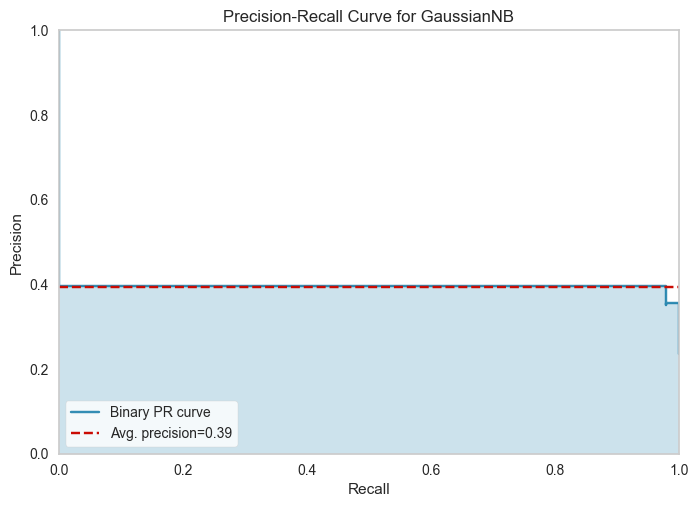

In [87]:
# plot precision-recall curve
exp8.plot_model(exp8_tuned_bm, plot='pr')

<b>Comment</b>:
- Precision-recall (PR) curve represents the trade-off between precision and recall for a binary classification model across different decision thresholds.
- As shown on the PR curve, the model's performance remains relatively constant across different decision thresholds, resulting in a flat curve. This could be attributed to several factors.
    - Since the model prioritizes F2 score which sacrifices precision over recall, the curve becomes flat.
    - The flat curve can also be causd by the inherent assumption of the model such as feature independence and Gaussian distribution.

#### <b>ROC-AUC</b>
This plot indicates how well a binary classifier (Gaussian Naive Bayes) performs at distinguishing between two classes. This informs the trade-off between FPR and TPR for varying thresholds.
- <b>False Positive Rate</b> (FPR, $x$-axis): Proportion of negative instances incorrectly classified as positive. $$FPR=\frac{FP}{FP + TN}$$
- <b>True Positive Rate</b> (TPR, $y$-axis): Proportion of positive instances correctly classified as positive. $$TPR=\frac{TP}{TP + FN}$$ 

In general, the higher the AUC score, the better the model is at predicting 0 (Not Canceled) as 0 and 1 (Canceled) as 1.

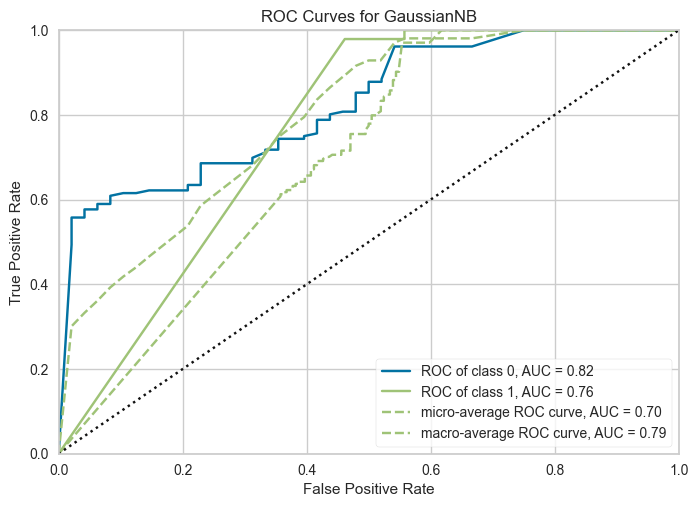

In [ ]:
# plot roc-auc
exp8.plot_model(exp8_tuned_bm, plot='auc')

<b>Comment</b> 
- The AUC for class 1 (Canceled) is 0.76 which means the model does a reasonably good at distinguishing between bookings that will be canceled and those that won't. In an ideal scenario, the model has higher AUC for this class so the model can better catching true cancellations.
- For class 0, the AUC score is 0.82, higher than the score of class 1. While this score is less relevant to the business goal to reduce the type II errors, this is still useful to indicate that the model is quite good at identifying bookings that will not be canceled.
- The micro-average AUC (0.70) considers the aggregate contributions of all classes whereas the macro-average AUC (0.79) considers the metric independently for each class and then takes the average. They give sense of how well the model is doing overall.
- In short, the model performs well at both classifying cancellations and non-cancellations but the performance for catching cancellations (Class 1) could be further improved.

#### <b>Classification Report</b>

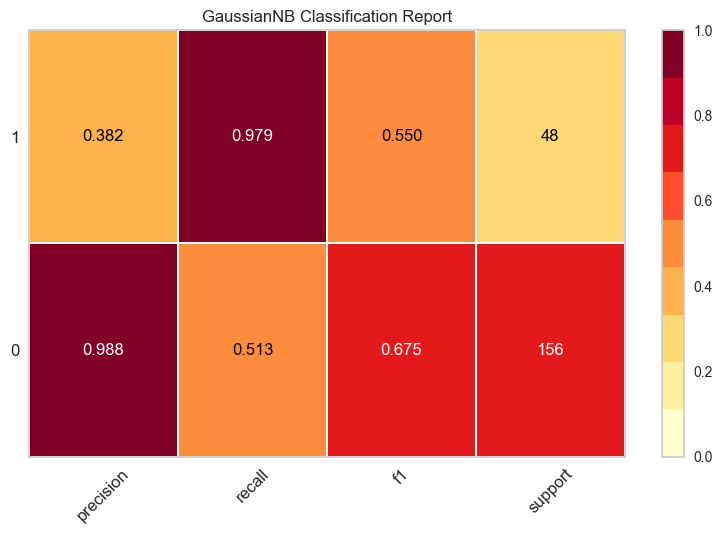

In [ ]:
# print classification report
exp8.plot_model(exp8_tuned_bm, plot='class_report')

<b>Comment</b>:
- <b>General observation</b>
    - The model has high recall but low precision for class 1, possibly suggesting a bias towards predicting class 1 more often even though class imbalance issue has been handled using nearmiss. 
    - For class 1: The model is highly sensitive, correctly identifying 97.79% of actual class 1 instances but the model seems to suffer from lack of precision with only 38.2% of its class 1 predictions being correct.
    - For class 0: The model is very precise as seen from the precision score, i.e., 98.8% of instances it identifies as class 0 but less sensitive as it identifies only 51.3% of all actuall class 0 instances. This implies a potential bias towards class 0 (Not Canceled).
- <b>In business context</b>
    - Class 1 (Canceled Booking): High recall (97%) indicates the model is good at identifying actual cancellations (reducing Type II errors for this class). This aligns with the goal of this project to minimize the financial cost associated with missed cancellations. Accurately identifying cancellations helps in taking proactive measures to mitigate associated losses.
    - Class 0 (Not Canceled): Lower recall (51.3) suggests that the model misses many true negatives (i.e., identifying cancellations as non-cancellations). Although this leads to some unnecessary actions, such errors are less financially costly than missing a cancellation. Hence, the lower recall for class 0 contributes less weight to the overall $F_2$ score.

#### <b>Learning Curve</b>
This plot displays how a model performs as the training set increases. This plot will evaluate the scalability of the model.

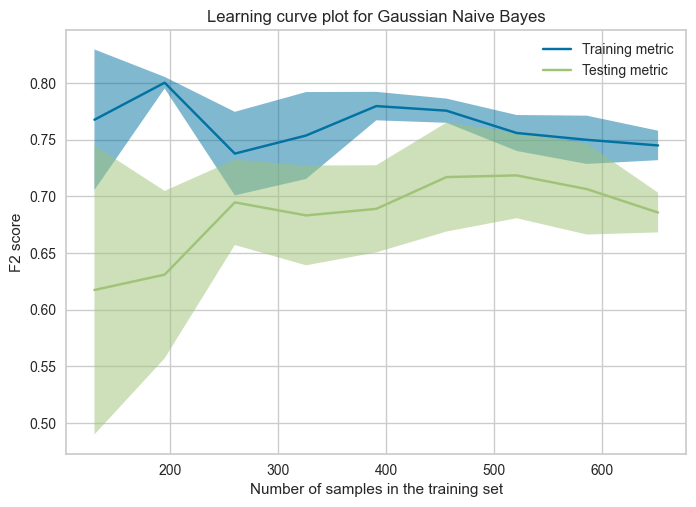

In [95]:
# plot learning curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import fbeta_score, make_scorer

ftwo_scorer = make_scorer(fbeta_score, beta=2)

X = exp8.get_config("X_train")
y = exp8.get_config("y_train")

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "score_type": "both",
    "cv": 5,
    "scoring": ftwo_scorer,
}

lc_display = LearningCurveDisplay.from_estimator(exp8_tuned_bm, **common_params)

# Adjust y-axis limits
# plt.ylim(0, 1)

# lc_display.plot()
plt.title('Learning curve plot for Gaussian Naive Bayes')
plt.ylabel("F2 score")
plt.show()


<b>Comment</b>
- The training score (blue line) starts high and slightly decreases, indicating the model initially fits the training data well.
- The testing score (green line) begins low and increases, showing the model gets better at predicting new data.
- The lines converge around $F_2$=0.75, suggesting that adding more data can be helpful for the model to perform consistently on both training and testing data.
- In short, although the model doesn't not show any signs of underfitting or overfitting, the model can potentially perform better when the number of data increases.

#### <b>Reliability Curve</b>
Reliability curve or calibration plot evaluates the predicted probabilities of the classifier matching the actual values. There are three possible outcomes shown by the reliability curve. 
- The expected result will be a diagonal line (perfect calibrated model) where the predicted probabilities reflect tur probabilities of the target.
- However, sometimes there will be some deviations from the diagonal line. 
    - Line above the diagonal one indicates the model overestimate the probabilities of the positive cases.
    - Line under the diagonal line implies an underestimation of the probabilities of positive cases.

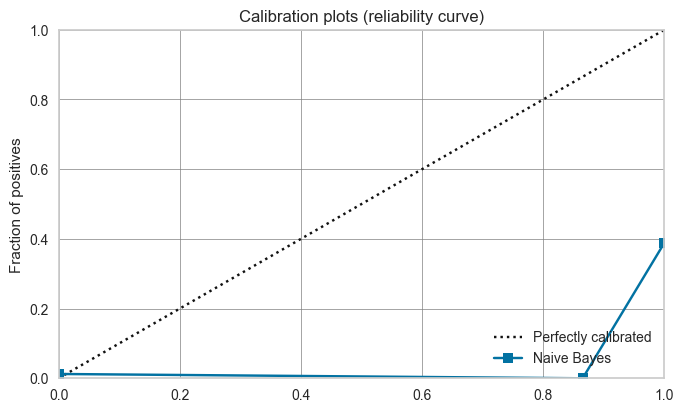

In [91]:
# plot calibration
exp8.plot_model(exp8_tuned_bm, plot='calibration')

<b>Comment</b>
- For most predicted probabilities, the reliability curve shows lies under the diagonal line, showing that the model consistently underpredicting the probabilities of positive outcomes. 
- For this reason, this model should be calibrated using isotonic regression to improve the calibration of the probabilities. Isotonic regression is flexible as it does not assume any specific form of relationship between the predicted probabilities and the actual outcomes.

In [90]:
# calibrate model
exp8_calibrated = exp8.calibrate_model(exp8_tuned_bm, method='isotonic')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
Fold,,,,,,,,
0,0.7317,0.7845,0.8947,0.4595,0.6071,0.4338,0.4895,0.7522
1,0.6951,0.7811,0.9474,0.4286,0.5902,0.3981,0.4781,0.7627
2,0.7073,0.7891,1.0000,0.4419,0.6129,0.4296,0.5230,0.7983
3,0.7317,0.8216,0.9474,0.4615,0.6207,0.4490,0.5188,0.7826
4,0.6098,0.7469,0.8947,0.3617,0.5152,0.2763,0.3570,0.6911
5,0.6829,0.7363,0.8500,0.4250,0.5667,0.3578,0.4115,0.7083
6,0.5926,0.7852,0.8421,0.3478,0.4923,0.2400,0.3064,0.6557
7,0.6667,0.7292,0.7895,0.3947,0.5263,0.3107,0.3553,0.6579
8,0.7284,0.7797,0.8421,0.4571,0.5926,0.4146,0.4582,0.7207


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

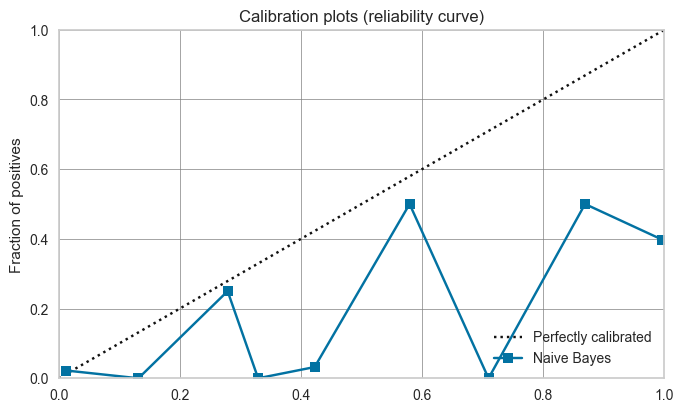

In [91]:
# plot calibration 
exp8.plot_model(exp8_calibrated, plot='calibration')

<b>Comment</b>
- Generally, in comparison to the uncalibrated verion above, the after-calibration model shows some improvements in some regions but still indicates some miscalibration.
- Even though the performance is still not well calibrated as seen from the reliability curve, the calibrated version still provides more reliable probabilities for each prediction.

# <b>5 Model Finalization & Explanation</b>

## <b>5.1 Model Finalization</b>

In [92]:
# finalize model
final_mdl = exp8.finalize_model(exp8_calibrated)

# print model
final_mdl

Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
         steps=[('onehot',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop='first',
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='error',
                                                                                             max_categories=N...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3))))),
                ('actual_estimator',
                 CalibratedClassifierCV(base_estimator=GaussianNB(priors=None,
                                                                  var_smoothing=7e-07),
                                        cv=5, ensemble=True, estimator=None,
                                        method='isotonic', n_jobs=None))],
         verbose=False)

<b>Comment</b>: Below is the pipeline of the modeling:
- <b>Categorical feature transformation</b>
    - This step focuses on the `customer_type` feature in the data. It uses one-hot encoding, which converts the categorical values in the column into numerical features.
    - Another categorical column, namely `reserved_room_type`, is transformed using a binary encoder. 
- <b>Class imbalance treatment</b>
    - This step handles class imbalance in the target variable (`is_canceled`)
    - The pipeline uses a "NearMiss" technique to address this.
- <b>Machine learning model training</b>
    - The pipeline uses a Gaussian Naive Bayes model as the base learner.
    - To further improve the model's performance, a technique called "CalibratedClassifierCV" is applied.
    - This involves training multiple versions of the model with different data splits and then calibrating the probabilities it outputs to make them more reliable.

In [95]:
# save model
exp8.save_model(final_mdl, '../model/final_model', verbose=False)

(Pipeline(memory=FastMemory(location=/var/folders/lt/w7rn9x3n1dl812m_1qp6j_j00000gp/T/joblib),
          steps=[('onehot',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=TransformerWrapper(exclude=None,
                                                                    include=['customer_type'],
                                                                    transformer=OneHotEncoder(categories='auto',
                                                                                              drop='first',
                                                                                              dtype=<class 'numpy.float64'>,
                                                                                              handle_unknown='error',
                                                                                              max_categories=N...
                                     transformer=Transfor

## <b>5.2 How Naive Bayes works: The basics</b>
- Naive Bayes is a classification algorithm using Bayes' theorem with the assumtion that features are independent given the class (Canceled vs Not Canceled). The concept "independent" here means that the value of a feature does not provide any information about that of another feature.
    - Bayes' theorem $$P(A|B)=\frac{P(B|A)\times P(A)}{P(B)}$$
    - When we put this into hotel cancellation context $$P(\text{canceled|features})=\frac{P(\text{features|canceled}) \times P(\text{canceled})}{P(\text{features})}$$
- This algorithm calculatees the probability of each class based on the probability of the class and the likelihood of the features.
- As an illustration, let's take a look at the snippet of the dataset below. To note, this is a simplified version as it doesn't take all features associated to the cancellation status (0: Not Canceled, 1: Canceled) into account.

$$
\begin{align}
P(\text{Cancelled}) &= \frac{\text{Cancelled Cases}}{\text{Total bookings}} = \frac{1}{6} = 0.167\\
P(\text{Not Cancelled}) &= \frac{\text{Not Cancelled Cases}}{\text{Total bookings}} = \frac{5}{6} = 0.833
\end{align}
$$

In [96]:
# for illustration only
df.loc[:5, ['previous_cancellations', 'customer_type', 'is_canceled']]

,previous_cancellations,customer_type,is_canceled
0,0,Transient-Party,0
1,0,Transient,0
2,0,Transient,0
3,0,Transient,1
4,0,Transient,0
5,0,Transient-Party,0


- First, we compute the prior probabilities of each class (is_canceled = 0 or 1):
    - Total bookings: 6
    - Number of cancellations (`is_canceled = 1`): 1
    - Number of non-cancellations (`is_canceled = 0`): 5
- So the prior probabilities are:
$$
\begin{align}
P(\text{Cancelled}) &= \frac{\text{Cancelled Cases}}{\text{Total bookings}} = \frac{1}{6} = 0.167\\
P(\text{Not Cancelled}) &= \frac{\text{Not Cancelled Cases}}{\text{Total bookings}} = \frac{5}{6} = 0.833
\end{align}
$$
- Second, calculate the likelihood of each feature value given cancellation statuses (canceled or not canceled)
    - For `customer_type` when `is_canceled = 1`
        - `Transient`: 1 (all cancelled bookings are Transient)
        - `Transient-Party`: 0
    - For `customer_type` when `is_canceled = 0`
        - `Transient`: 3 out of 5
        - `Transient-Party`: 2 out of 5
- So the likelihoods are
$$
\begin{align*}
P(\text{customer\_type} = \text{Transient} \mid \text{is\_canceled} = 1) &= 1.0 \\
P(\text{customer\_type} = \text{Transient-Party} \mid \text{is\_canceled} = 1) &= 0.0 \\
P(\text{customer\_type} = \text{Transient} \mid \text{is\_canceled} = 0) &= 0.6 \\
P(\text{customer\_type} = \text{Transient-Party} \mid \text{is\_canceled} = 0) &= 0.4 \\
\end{align*}
$$
- For `previous_cancellations`, all values are 0, meaning no previous cancellation for the customers.

$$
P(\text{previous\_cancellations} = 0 \mid \text{is\_canceled} = 1) = 1.0 \\
P(\text{previous\_cancellations} = 0 \mid \text{is\_canceled} = 0) = 1.0
$$
- Now, let's predict for a new booking with `previous_cancellations = 0` and `customer_type = Transient` using Bayes theorem: $$P(\text{canceled|features})=\frac{P(\text{features|canceled}) \times P(\text{canceled})}{P(\text{features})}$$
$$
\begin{align}

P(\text{canceled|features}) &= P(\text{previous\_cancellations = 0|canceled}) \times P(\text{customer\_type = Transient|canceled}) \times P(\text{canceled}) \\
&=\frac{5}{6} \times \frac{0}{6} \times \frac{1}{6}\\
&= 0 \\

P(\text{not canceled|features}) &= P(\text{previous\_cancellations = 0|not canceled}) \times P(\text{customer\_type = Transient| not canceled}) \times P(\text{not canceled}) \\
&=\frac{5}{6} \times \frac{1}{6} \times \frac{5}{6}\\
&= 0.231 \\
\end{align}
$$
- Based on these calculations, the Naive Bayes classifier would predict that the booking will not be canceled.

## <b>5.3 How Naive Bayes work: Counterfactual explanations</b>

In [110]:
import dice_ml

continuous_features = ['previous_cancellations', 
                       'booking_changes', 
                       'days_in_waiting_list', 
                       'required_car_parking_spaces', 
                       'total_of_special_requests']

# prepare the data
X_test = exp8.get_config('X_test')
df_train = exp8.get_config('X_train')
df_train['is_canceled'] = exp8.get_config('y_train')
data_dice = dice_ml.Data(dataframe=df_train, 
                         continuous_features=continuous_features, 
                         outcome_name='is_canceled')

# model
rf_dice = dice_ml.Model(model=final_mdl, backend="sklearn")

# explainer
explainer = dice_ml.Dice(data_dice, rf_dice, method="kdtree")

# generate counterfactuals 
cf = explainer.generate_counterfactuals(X_test[0:1], total_CFs=3, desired_class="opposite")

# show dataframe
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

Query instance (original outcome : 0)


,previous_cancellations,booking_changes,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,0,1,0,Transient,D,1,0,0



Diverse Counterfactual set (new outcome: 1)


,previous_cancellations,booking_changes,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
20,-,0,-,-,-,0,-,1
112,-,-,-,-,F,0,-,1
131,-,-,-,-,E,0,-,1


<b>Comment</b>
- Counterfactual explanation is an model explanation method using a hypothetical scenario contradicting the observed facts.
- In the original booking scenario (first dataframe), the model predicted that the booking will not be canceled. However, by analyzing counterfactual scenarios, it is found that certain changes in the booking details lead to a different prediction:
    - If the the number of changes in bookings become zero, the model predicts a cancellation. This demonstratees that the model considers a history of bookings as a strong indicator of a future cancellation.
    - If the reserved room type changes from D to either F or E, the prediction changes to a cancellation. This suggests that room type F and E are more prone to cancellations.

## <b>5.3 Prediction on train and test set</b>

In [ ]:
# print config
print(exp8.get_config())

{'USI', 'X', 'dataset', 'X_test_transformed', 'test', 'logging_param', '_ml_usecase', 'dataset_transformed', '_available_plots', 'X_train_transformed', 'train_transformed', 'pipeline', 'y_test_transformed', 'data', 'X_test', 'gpu_n_jobs_param', 'html_param', 'train', 'y_train_transformed', 'test_transformed', 'fold_groups_param', 'log_plots_param', 'fold_shuffle_param', 'target_param', 'y_train', 'memory', 'X_train', 'exp_name_log', 'y', 'variable_and_property_keys', 'idx', 'seed', 'exp_id', 'y_test', 'gpu_param', 'fold_generator', 'is_multiclass', 'n_jobs_param', 'variables', 'fix_imbalance', 'y_transformed', 'X_transformed'}


In [ ]:
# access training and test data
X_train = exp8.get_config('X_train')
y_train = exp8.get_config('y_train')
X_test = exp8.get_config('X_test')
y_test = exp8.get_config('y_test')

In [ ]:
# get predictions on train set
train_predictions = exp8.predict_model(final_mdl, data=pd.concat([X_train, y_train], axis=1))

# get predictions on test set
test_predictions = exp8.predict_model(final_mdl, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
0,Naive Bayes,0.7243,0.8200,0.8586,0.4530,0.5931,0.4134,0.4618,0.7282


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
0,Naive Bayes,0.6814,0.7935,0.9375,0.4206,0.5806,0.3789,0.4587,0.7525


In [ ]:
# get predictions on train set
exp8.predict_model(final_mdl, data=exp8.get_config('train')).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
0,Naive Bayes,0.7243,0.8200,0.8586,0.4530,0.5931,0.4134,0.4618,0.7282


,previous_cancellations,booking_changes,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score
34346,0,0,0,Transient,A,2,0,0,0,0.5685
64029,0,4,0,Transient-Party,F,1,0,0,0,0.6116
8990,0,3,0,Transient,A,0,3,0,0,0.5402
67650,0,1,0,Transient-Party,E,1,1,0,0,0.6116
58688,0,0,0,Transient,F,2,1,0,0,0.5685


In [ ]:
# get predictions on test set
exp8.predict_model(final_mdl).head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
0,Naive Bayes,0.6814,0.7935,0.9375,0.4206,0.5806,0.3789,0.4587,0.7525


,previous_cancellations,booking_changes,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score
294,0,1,0,Transient,D,1,0,0,0,0.6116
81367,2,1,0,Transient,A,0,4,1,0,0.6116
46479,0,7,0,Transient,F,0,1,0,1,0.5629
4530,0,1,0,Transient-Party,D,1,0,0,0,0.6116
12951,0,0,30,Transient,A,0,0,1,1,0.5829


<b>Comment</b>
- The Gaussian Naive Bayes Classifier achieves an $F_2$ score of 0.7282 on the training set and 0.7525 on the test set.
- The better perforance on the test set means that model performs better on this dataset, and hence a good indication of generalization.

## <b>5.4 Permutation Importance</b>

- As Gaussian Naive Bayes assumes independence of features in predicting class and doesn't have coefficients like in other models (e.g., logistic regression), this model doesn't have a built-in method for calculating feature importance. 
- For this reason, my estimation of feature importance uses permutation which is more model-agnostic (applicable to various model types and not limited to the inner workings of a particular model). 
- This technique focuses on the decrease in the model's performance when a specific feature's values are shuffled (rather than removed entirely). 
- By observing how much the performance drops in the shuffle, we can see how impactful a feature is. 
- In general, the greater the decrease in model's performance, the more important the feature is.

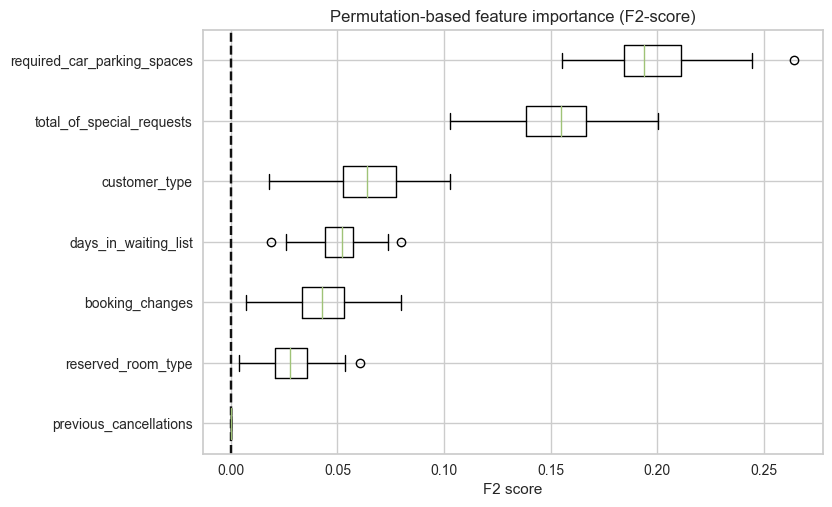

In [118]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, fbeta_score
import matplotlib.pyplot as plt

# specify metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# define X_test and y_test
X_train = exp8.get_config('X_train')
y_train = exp8.get_config('y_train')

# plot permutation importance
result = permutation_importance(final_mdl, X_train, y_train, n_repeats=100, random_state=42, n_jobs=-1, scoring=ftwo_scorer)
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False,
        labels=X_train.columns[perm_sorted_idx])
plt.axvline(x=0, color="k", linestyle="--")
plt.title("Permutation-based feature importance (F2-score)")
plt.xlabel("F2 score")
plt.show()

<b>Comment</b>
- The `required_car_parking_spaces` has the highest importance, suggesting that the number of parking spaces required by a guest is a strong predictor of cancellation.
- `total_of_special_requests` ia also an important feature, indicating that the number of special requests made by a guest can influence the likelihood of cancellation.
- `customer_type` also has a notable impact on the cancellation predictions.
- The rest features such as `days_in_waiting_list`, `booking_changes`, `reserved_room_type`, and `previous_cancellations` have lower importance.

In [ ]:
# make predictions
result = exp8.predict_model(final_mdl, data=df_seen, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2
0,Naive Bayes,0.7157,0.8151,0.8745,0.4456,0.5904,0.4060,0.4603,0.7333


In [127]:
# discretize prediction score 1
bin= pd.cut(result['prediction_score_1'], bins=10, labels=False)
result['group'] = bin
bin_counts = result['group'].value_counts().sort_index()

# see result
result.head(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,prediction_label,prediction_score_0,prediction_score_1,group
31086,GBR,Corporate,0,0,No Deposit,12,Transient-Party,A,0,0,0,1,0.4171,0.5829,9
20887,CHE,Direct,0,2,No Deposit,0,Transient,C,0,1,0,1,0.4920,0.5080,6
4943,BRA,Direct,0,3,No Deposit,0,Transient,E,1,1,0,0,0.5885,0.4115,1
29579,NLD,Online TA,0,0,No Deposit,0,Transient,E,0,4,0,0,0.5560,0.4440,2
80255,BEL,Groups,0,1,No Deposit,185,Transient-Party,D,0,0,0,0,0.5798,0.4202,1
40002,NLD,Offline TA/TO,0,0,No Deposit,63,Transient-Party,A,0,1,0,0,0.6116,0.3884,0
11984,USA,Online TA,0,3,No Deposit,0,Transient,B,1,1,0,0,0.5685,0.4315,2
36894,PRT,Online TA,1,1,No Deposit,0,Transient,E,0,1,1,1,0.4920,0.5080,6
9827,PRT,Online TA,0,5,No Deposit,0,Transient,A,0,2,0,1,0.4371,0.5629,8
2500,ESP,Direct,0,3,No Deposit,0,Transient,E,0,1,0,1,0.4601,0.5399,7


In [129]:
# bin prediction scores
from sklearn.metrics import *
results = []
for i in result.group.unique():
    dt = result[result['group'] == i]
    if i <= 5:
        f1 = balanced_accuracy_score(dt['is_canceled'], dt['prediction_label'])
        recall = recall_score(dt['is_canceled'], dt['prediction_label'], pos_label=0)
        precision = precision_score (dt['is_canceled'], dt['prediction_label'], pos_label=0)
        f2 = fbeta_score(dt['is_canceled'], dt['prediction_label'], beta=2,pos_label=0)
    else:
        f1 = balanced_accuracy_score(dt['is_canceled'], dt['prediction_label'])
        recall = recall_score(dt['is_canceled'], dt['prediction_label'])
        precision = precision_score (dt['is_canceled'], dt['prediction_label'])
        f2 = fbeta_score(dt['is_canceled'], dt['prediction_label'], beta=2)

    results.append({
        'group': i,
        'accuracy': f1, 
        'recall': recall, 
        'precision': precision,
        'F2':f2
    })

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by='F2', ascending=False)
results_df

,group,accuracy,recall,precision,F2
2,1,1.0,1.0,1.000000,1.000000
4,0,0.5,1.0,0.963211,0.992419
3,2,0.5,1.0,0.959732,0.991678
9,4,0.5,1.0,0.800000,0.952381
8,3,0.5,1.0,0.785714,0.948276
7,5,0.5,1.0,0.700000,0.921053
0,9,0.5,1.0,0.506494,0.836910
6,7,0.5,1.0,0.500000,0.833333
5,8,0.5,1.0,0.360000,0.737705
1,6,0.5,1.0,0.284211,0.665025


In [ ]:
# see range of each groups
result.groupby('group').agg(func={'prediction_score_1':'describe'})

prediction_score_1                                                       \
                   count      mean       std     min     25%      50%     75%   
group                                                                           
0                  299.0  0.388406  0.000104  0.3884  0.3884  0.38840  0.3884   
1                   46.0  0.416607  0.004331  0.4115  0.4115  0.42020  0.4202   
2                  149.0  0.433283  0.004297  0.4315  0.4315  0.43150  0.4315   
3                   42.0  0.460131  0.001041  0.4597  0.4598  0.45980  0.4598   
4                    5.0  0.482260  0.002246  0.4798  0.4798  0.48390  0.4839   
5                   10.0  0.491950  0.000369  0.4916  0.4916  0.49195  0.4923   
6                   95.0  0.508787  0.002252  0.5080  0.5080  0.50800  0.5080   
7                   16.0  0.535075  0.004088  0.5311  0.5311  0.53470  0.5399   
8                   50.0  0.562428  0.002336  0.5511  0.5629  0.56290  0.5629   
9                  308.0  0.582874  0.000192  0.5813  0.5829  0.58290  0.5829   

               
          max  
group          
0      0.3902  
1      0.4202  
2      0.4440  
3      0.4633  
4      0.4839  
5      0.4923  
6      0.5189  
7      0.5399  
8      0.5629  
9      0.5829

<b>Comment</b>: 
- The model works best (based on $F_2$) in all groups, except group 6 and 8 in which the $F_2$ scores are below 0.7.
    - For group 6, the range of prediction scores is between 0.5080 and 0.5189.
    - For group 8, the range of prediction scores is between 0.5511 and 0.5629.

# <b>6 Conclusions & Recommendations</b>

## <b>6.1 Conclusions</b>
This project aims to develop a machine learning classification model to predict hotel booking cancellations with a focus on minimizing False Negative (Type II Error). A series of machine learning experiments on the hotel's historical data have been carried out to find the best model in achieving such goal. In general, this project consists of 7 experiments, utilizing different focuses. 
- <b>Experiment 1</b> was designed to be the baseline of the model performance, checking how good the original model performed. The best model of this experiment was compared to the results of the next-two experiments.
- <b>Experiment 2</b> used robust scaling to see if scaling numeric features with outliers could produce a better performing model.
- In <b>Experiment 3</b>, quantile binning (equal frequency discretization) was utilized to investigate to what extent binning features with outliers could affected the model. Among the first three experiments, this experiment yielded the best performing model. As a result, the setup was used in the following experiments.
- Continuing Experiment 3, <b>Experiment 4</b> added polynomial features to make the model easier in distinguishing targets. The rationale of this addition was the uneven distribution between the binary labels in the target variable.
- <b>Experiment 5</b> aimed to investigate the extent to which nearmiss version 3 could handle the imbalance label issue and produced the best model.
- <b>Experiment 6</b> is similar to Experiment 5 in which imbalanced label issue was sought to solve.
- Based on Experiment 4 to Experiment 6, the setup in Experiment 4 could gave the best performing model. The top-three best model from Experiment 4 were used to build a blended model in <b>Experiment 7</b>.
- While Experiment 4 produced higher $F_2$ score even compared to Experiment 7 (blended model), another experiment was carried out. This experiment addressed the issue of imbalanced labels which had not been treated in Experiment 4. This last experiment produced the highest $F_2$ score among all experiments.
- <b>Experiment 8</b> was conducted as a follow-up for Experiment 4 result as the best model. As experiment 4 did no take imbalanced class treatment into account, Experiment 8 addressed the problem by adding NearMiss v3.
The summary of experiment results can be seen on the image below.

![exp-flow](../image/newflow.png)

## <b>6.2 Cost saving simulation</b>
This section informs how well the model (Naive Bayes from Experiment 8 as the best model) performs in cost saving in comparison to the non-utilization of the ML model.

In [ ]:
# number of bookings
len(df_seen)

1020

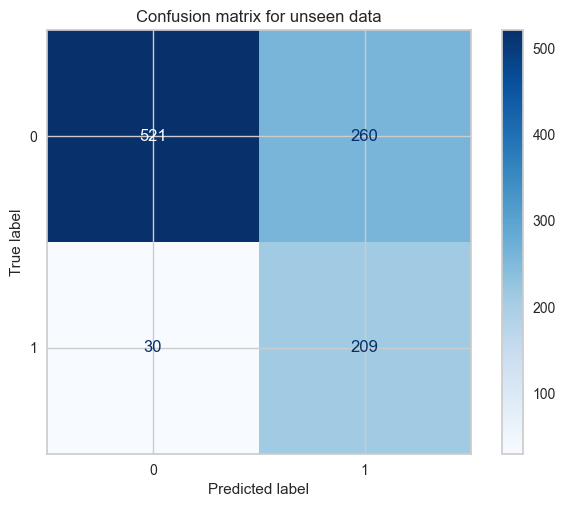

In [ ]:
# display confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(result['is_canceled'], result['prediction_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix for unseen data")
plt.show()

<b>Cost</b>
- Type I error (False positive): USD67.5 per booking (max price for room upgrade)
- Type II error (False negative): USD99 per booking

<b>Without model</b>: Assume there are 60% of incorrect predictions with false positives of 20% and false negatives of 40%. In total, the cost is USD54,162.
- False positives: 0.2 x 1020 = 204 $\Rightarrow$ 204 bookings x USD67.5 = USD13,770
- False negatives: 0.4 x 1020 = 408 $\Rightarrow$ 408 bookings x USD99 = USD40,394
- Total financial loss: USD54,162

<b>With model</b>: Based on the confusion matrix above, we have:
- TP (obs 1, pred 1): 209
- TN (obs 0, pred 0): 521
- FP (obs 0, pred 1): 260
- FN (obs 1, pred 0): 30

Given this confusion matrix information:
- Type I error (FP): 260 x USD67.5 = USD17,550
- Type II error (FN): 30 x USD99 = USD2,970

As a result, the model can save: USD54,162 - USD20,520 = USD33,642

## <b>6.3 Limitations</b>
To understand the limitations of the model, this part will use descriptive statistics. The evaluation on the model's evaluation is done on the training set (`df_seen`) because the model was trained using this sample. <b>Note</b>: Although the dataset contains `country`, `market_segment`, and `deposit_type`, these features were excluded in the modeling phase.

In [184]:
# get columns in the training set
df_seen.columns

Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled'],
      dtype='object')

In [185]:
# numerical features
df_seen.describe().round()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,1020.0,1020.0,1020.0,1020.0,1020.0,1020.0
mean,0.0,1.0,20.0,0.0,1.0,0.0
std,2.0,2.0,50.0,1.0,1.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,1.0,0.0,0.0,1.0,0.0
75%,0.0,2.0,4.0,1.0,2.0,0.0
max,26.0,21.0,391.0,8.0,5.0,1.0


In [186]:
# check unique values in reserved room types
df_seen['reserved_room_type'].unique()

array(['A', 'C', 'E', 'D', 'B', 'H', 'F', 'G', 'P', 'L'], dtype=object)

In [204]:
# check unique values in customer types
df_seen['customer_type'].unique()

array(['Transient-Party', 'Transient', 'Contract', 'Group'], dtype=object)

<b>Comment</b>
- The Naive Bayes model uses various features from the hotel booking data to predict cancellations. These features include a customer's cancellation history (`previous_cancellations`), booking modifications (booking_changes), waiting list status (`days_in_waiting_list`), parking needs (`required_car_parking_spaces`), and special requests (`total_of_special_requests`). 
- While these features provide insights into booking behavior, it's important to remember that Naive Bayes assumes features are independent of each other. 
- In reality, features like `booking_changes` and `days_in_waiting_list` might be correlated (customers who wait longer might make more changes). This limitation of the model could potentially affect its accuracy. 
- Additionally, the model handles categorical features like `customer_type` (transient party, transient, contract, group) by converting them into numerical representations internally.
- Now let's break down each variable.
    - `previous_cancellations`: the value ranges between 0 and 26 times. 
    - `booking_changes`: the value ranges between 0 and 21 times.
    - `days_in_waiting_list`: The waiting list is between 0 to 391 days.
    - `required_car_parking_spaces`: The hotel provides different number of parking spaces starting from 0 to 8 to accommodate guests parking their cars at the hotel.
    - `total_of_special_requests`: The number of special requests by the guests in total is between 0 and 5.
    - `reserved_room_type`: 10 types of rooms available in the hotel represented by letter A, B, C, D, E, F, G, H, P, and L.
    - `customer_type`: There are 4 types of customers in the training data, namely transient party, transient, contract, and group.
- This means that outside the described ranges the model's predictions will be inaccurate. 

<b>More note</b>
- It is crucial to acknowledge the inherent limitations of both data and the model to ensure a thorough understanding of this project's performance. 
- <b>Model</b>: First, given the assumption of feature independence in Naive Bayes, the model may not capture complex relationships between features, potentially leading to nonoptimal performance in scenarions where feature interdependences are crucial.
- <b>Time</b>: Due to the time constrains, this project can only take up to 8 experiments, leaving a number of possibilities to improve the model such as the use of feature selection or different experiment setups.

## <b>6.4 Recommendations</b>

<b>For Hotel Managers</b>
- Utilize the model's predictions to proactively manage bookings. For instance, if a booking is likely to be canceled, consider implementing strategies such as offering incentives or reaching out to guests to confirm their stays to minimize the impact of cancellations on revenue, occupancy rates, and operational efficiency.
- Evaluate the impact of the model-driven decisions on operational improvements, e.g., by using A/B testing. The evaluation can cover metrics such as cancellation rate and revenue during a specific period to determine the effectiveness of the classification model in optimizing hotel operations.
- Optimize operational resource allocation based on cancellation predictions to minimize waste and maximize efficiency. Allocate staff, inventory, and services in alignment with expected booking patterns and anticipated cancellations, ensuring optimal utilization of resources.

<b>For Future Directions</b>
- Improve the data quality due to a great number of duplicates in the dataset prior to data cleaning by collecting more data to increase the size of the dataset which can improve the model's performance and generalization ability.
- While we already implemented a series of experiments with a number of setups, including different algorithms and feature engineering techniques, to handle various problems in the dataset such as imbalanced labels and outliers, try to perform experiments with another setup. This potentially yields a better performing model based on F2.

# <b>References</b>
Brownlee, J. (2020). *Imbalanced classification with Python: Better metrics, balance skewed classes, cost-sensitive learning*. Machine Learning Mastery.

<h1 style='text-align:center'>---End---</h1>